### DOWNLOAD REPO

In [80]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


### CODE+HELPERS+CLASSES

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import matplotlib.ticker as ticker
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import random
import datetime
import matplotlib.animation as animation
import json
import os

class Battery():
    """
    Class that creates a battery with coordinates and capacity
    """
    def __init__(self, x, y, capacity):

        #coordinates
        self.x = x
        self.y = y

        # capacity of battery
        self.max_capacity = capacity

        self.current_capacity = 0

        # list of houses connected to battery per battery is stored here
        self.connected_houses = []

        # list of cables connecxted to battery per battery is stored here
        self.cables = {}

        self.color = None


    def connect_house(self, house):
        """
        If a house is not connected to a battery yet, it is added to the list of connected houses
        """
        if house not in self.connected_houses:
            self.connected_houses.append(house)
            self.current_capacity += house.maxoutput

    def can_connect(self, house):
            """
            Checks if a house can be connected to the battery without exceeding its capacity.
            """
            total_power = sum(house.maxoutput for house in self.connected_houses)
            if (total_power + house.maxoutput) <= self.max_capacity:
                return True  # The house can be connected
            else:
                return False  # The house cannot be connected due to capacity constraints


class Cable:
    """
    Class that creates a cable with coordinates and an id
    """
    def __init__(self, start_x, start_y, end_x, end_y, battery = None):

        # Coordinates
        self.start_x = start_x
        self.start_y = start_y
        self.end_x = end_x
        self.end_y = end_y

        # As the cables are used in the algorithm, the x and y coordinates are used as the current position of the cable
        self.x = start_x
        self.y = start_y

        # Create an id for the cable
        self.id = f"{start_x},{start_y}, {end_x}, {end_y}"

        # Every cable can be connected to a battery and this is stored in this attribute
        self.connected_battery = battery

class House():
    """
    Class that creates a house with coordinates and max output
    """
    def __init__(self, x, y, maxoutput):
        self.x = x
        self.y = y

        #houses output
        self.maxoutput = maxoutput

        # Set the connected route battery to None
        self.route = []



In [82]:

def draw_cables(district):
    """
    This file contains the code to plot the houses and batteries with the Manhattan-style cables used in the experiment class
    """
    # Create an instance of the Experiment clas
    experiment_instance = district


    # Create a figure and 50x50 grid
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks(np.arange(0, 51, 1))
    ax.set_yticks(np.arange(0, 51, 1))

    # Draw grid with grey lines
    ax.grid(linestyle='-', linewidth='0.5', alpha=0.25, color='grey', zorder=0)

    # Draw thicker grey lines for every 10th line
    for i in range(0, 51, 10):
        ax.axvline(x=i, color='grey', linestyle='-', linewidth=1.5, alpha=0.25, zorder=0)
        ax.axhline(y=i, color='grey', linestyle='-', linewidth=1.5, alpha=0.25, zorder=0)

    # Set labels for every 10th line
    ax.set_xticklabels([str(i) if i % 10 == 0 else '' for i in np.arange(0, 51, 1)])
    ax.set_yticklabels([str(i) if i % 10 == 0 else '' for i in np.arange(0, 51, 1)])

    # Plot houses
    for house in experiment_instance.houses:
        plt.scatter(house.x, house.y, color='blue', label='House')

    # Set total cost to 0
    total_cost = 0

    # Plot batteries
    for battery in experiment_instance.batteries:
        plt.scatter(battery.x, battery.y, color='yellow', edgecolors='black', linewidth=0.5, marker='s', label='Battery')

        # Add 5000 to the total cost for every battery
        total_cost += 5000

        # Calculate and annotate total output and total cables for each battery
        total_output = sum(house.maxoutput for house in battery.connected_houses)

        # Create a set of all cables connected to the battery
        battery_cables = set()

        # Add all cables connected to the battery to the set
        for house in battery.connected_houses:

            # Loop over cables
            for cable in house.route:

                # Check if the cable is connected to the battery
                battery_cables.add(cable)

        # Calculate the total cables used
        total_cables = len(battery_cables)

        # Ecery cable adds 9 to the total cost
        total_cost += total_cables * 9

        # Annotate the battery with the total output and total cables
        plt.annotate(f'Output: {total_output}\nCables: {total_cables}',
                    (battery.x, battery.y), textcoords="offset points",
                    xytext=(0,10), ha='right', fontsize=12, color='black')

    battery_colors = ['orange', 'green', 'red', 'blue', 'purple']
    # Plot cables

    for i in range(len(experiment_instance.batteries)):

        for cable in experiment_instance.cables:
            if cable.connected_battery == experiment_instance.batteries[i]:
                plt.plot([cable.start_x, cable.end_x], [cable.start_y, cable.end_y],
                linewidth=0.5, color=battery_colors[i], zorder=0)

    # Add the total cost of the district to the plot
    plt.annotate(f'Total cost: {total_cost}', (0, 0), textcoords="offset points",
                xytext=(10,10), ha='left', fontsize=12, color='black')

    plt.title('Houses and Batteries with Manhattan-style Cables')
    plt.show()


def load_battery_data(filename):
    '''
    reads the csv file and returns a dictionary with the positions of the batteries and their capacity

    '''

    # # create new dict
    battery_data = {}

    with open(filename, 'r') as f:

        csv_reader = csv.reader(f)

        # skip the header
        next(csv_reader)

        for row in csv_reader:

            position = map(int, row[0].split(','))

            capacity = row[1]

            battery_data[tuple(position)] = float(capacity)

    return battery_data


def load_house_data(house_data):
    """
    reads the csv file and returns a dictionary with the x and y positions of the houses and their max output

    """

    house_dict = {}

    with open(house_data, 'r') as file:

            reader = csv.reader(file)

            # skip the header
            next(reader)

            for row in reader:

                x = row[0]
                y = row[1]
                maxoutput = row[2]

                house_dict[tuple((int(x),int(y)))] = float(maxoutput)

    return house_dict


def show_district(houses_data, battery_data):

    # load data
    houses = load_house_data(houses_data)
    batteries = load_battery_data(battery_data)

    # grid of 50 x 50 with small lines
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(0, 51, 1))
    ax.set_yticks(np.arange(0, 51, 1))

    # Design of the grid (thin lines and in background)
    ax.grid(linestyle='-', linewidth='0.5', alpha=0.25, color='grey', zorder = 0)


    # thicken every 10th line for overview
    for i in range(0, 51, 10):
        ax.axvline(x=i, color='grey', linestyle='-', linewidth = 1.5, alpha=0.25, zorder = 0)
        ax.axhline(y=i, color='grey', linestyle='-', linewidth = 1.5, alpha = 0.25, zorder = 0)

    # label every 10th line for overview
    ax.set_xticklabels([str(i) if i % 10 == 0 else '' for i in np.arange(0, 51, 1)])
    ax.set_yticklabels([str(i) if i % 10 == 0 else '' for i in np.arange(0, 51, 1)])


    #plotting houses and batteries
    for house in houses.values():
        ax.scatter(house.x, house.y, color="blue", label="house")

    for battery in batteries.values():
        ax.scatter(battery.x, battery.y, color="red", marker="s", label="battery")

    #label every 10th line
    ax.set_xticklabels([str(i) if i % 10 == 0 else '' for i in range(0, 51)])
    ax.set_yticklabels([str(i) if i % 10 == 0 else '' for i in range(0, 51)])

    # Show the plot
    plt.show()

def simple_state_space(houses, batteries, max_connections_per_battery):
    if batteries == 0:
        if houses == 0:
            return 1
        else:
            return 0

    if houses > batteries * max_connections_per_battery:
        return 0

    count = 0

    for i in range(min(houses, max_connections_per_battery)+1):
        count += simple_state_space(houses - i, batteries - 1, max_connections_per_battery)

    return count


def visualize(district, district_number):
    """
    This file contains the code to plot the houses and batteries with the Manhattan-style cables used in the experiment class
    """
    # Create an instance of the Experiment clas
    experiment_instance = district


    # Create a figure and 50x50 grid
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks(np.arange(0, 51, 1))
    ax.set_yticks(np.arange(0, 51, 1))

    # Draw grid with grey lines
    ax.grid(linestyle='-', linewidth='0.5', alpha=0.25, color='grey', zorder=0)

    # Draw thicker grey lines for every 10th line
    for i in range(0, 51, 10):
        ax.axvline(x=i, color='grey', linestyle='-', linewidth=1.5, alpha=0.25, zorder=0)
        ax.axhline(y=i, color='grey', linestyle='-', linewidth=1.5, alpha=0.25, zorder=0)

    # Set labels for every 10th line
    ax.set_xticklabels([str(i) if i % 10 == 0 else '' for i in np.arange(0, 51, 1)])
    ax.set_yticklabels([str(i) if i % 10 == 0 else '' for i in np.arange(0, 51, 1)])

    #load the image for houses and batteries
    house_image = plt.imread("data/Huizen&Batterijen/Images/housy.png")
    battery_image = plt.imread("data/Huizen&Batterijen/Images/battery.png")

    def plot_house(img, x, y):
        image = OffsetImage(img, zoom=0.03)
        ab = AnnotationBbox(image, (x,y), frameon=False)
        ax.add_artist(ab)

    def plot_battery(img, x, y):
        image = OffsetImage(img, zoom=0.01)
        ab = AnnotationBbox(image, (x,y), frameon=False)
        ax.add_artist(ab)

    # Plot houses
    for house in experiment_instance.houses:
        plot_house(house_image, house.x, house.y)

    # Set total cost to 0
    total_cost = 0

    # Store the colors of the batteries to later give the cables that color
    battery_colors = ['orange', 'green', 'red', 'blue', 'purple']
    # Plot batteries
    for battery in experiment_instance.batteries:
        plot_battery(battery_image, battery.x, battery.y)

        # Add 5000 to the total cost for every battery
        total_cost += 5000

        # Calculate and annotate total output and total cables for each battery
        total_output = sum(house.maxoutput for house in battery.connected_houses)

        # Create a set of all cables connected to the battery
        battery_cables = set()

        # Add all cables connected to the battery to the set
        for house in battery.connected_houses:

            # Loop over cables
            for cable_id in house.route:

                # Check if the cable is connected to the battery
                battery_cables.add(cable_id)

        # Calculate the total cables used
        total_cables = len(battery_cables)

        # Every cable adds 9 to the total cost, since this is the cost formula
        total_cost += total_cables * 9

        # Annotate the battery with the total output and total cables
        plt.annotate(f'Output: {total_output}\nCables: {total_cables}',
                    (battery.x, battery.y), textcoords="offset points",
                    xytext=(0,10), ha='right', fontsize=12, color='black')

    # Plot cables
    for i in range(len(experiment_instance.batteries)):

        #loop over the cables in experiment and look for the colors by ID so it plots cable colors per battery
        for cable_id, cable in experiment_instance.cables.items():
            if cable.connected_battery == experiment_instance.batteries[i]:
                plt.plot([cable.start_x, cable.end_x], [cable.start_y, cable.end_y],
                linewidth=0.5, color=battery_colors[i], zorder=0)

    # Add the total cost of the district to the plot
    plt.annotate(f'Total cost: {total_cost}', (0, 0), textcoords="offset points",
                xytext=(10,10), ha='left', fontsize=12, color='black')

    plt.title('Houses and Batteries with Manhattan-style Cables')
    # plt.savefig(f"data/output_data/plots/district{district_number}.png")
    plt.show()





In [83]:
class District:
    """
    Class that creates a district with houses and batteries
    """
    def __init__(self, houses_file, batteries_file):
        # Load houses and batteries
        house_dict = load_house_data(houses_file)
        battery_dict = load_battery_data(batteries_file)

        # Create houses and batteries using the data
        self.houses = [House(x, y, maxoutput) for (x, y), maxoutput in house_dict.items()]
        self.batteries = [Battery(x, y, capacity) for (x, y), capacity in battery_dict.items()]
        self.cables = {}

    def load_houses(self, file_path):
        """
        This method loads in the houses from a csv file and returns a list of houses
        """

        # create empty list for houses
        houses = []

        # open file and read in the data
        with open(file_path, 'r') as file:
            reader = csv.DictReader(file)
            for row in reader:
                house = House(int(row['x']), int(row['y']), float(row['maxoutput']))
                houses.append(house)
        return houses



    def load_random_houses(self, file_path):
        """
        This method loads in the houses from a csv file and returns a list of houses and shuffles them
        """

        # create empty list for houses
        houses = []

        # open file and read in the data
        with open(file_path, 'r') as file:
            reader = csv.DictReader(file)
            for row in reader:
                house = House(int(row['x']), int(row['y']), float(row['maxoutput']))
                houses.append(house)

        # shuffle houses
        random.shuffle(houses)
        return houses


    def load_batteries(self, file_path):
        """
        This method loads in the batteries from a csv file and returns a list of batteries
        """

        # create empty list for batteries
        batteries = []

        # open file and read in the data and create batteries

        with open(file_path, 'r') as file:
            reader = csv.DictReader(file)
            for row in reader:
                x, y = map(int, row['positie'].split(','))
                battery = Battery(x, y, float(row['capaciteit']))
                batteries.append(battery)
        return batteries

    def load_random_batteries(self, file_path):
        """
        This method loads in the batteries from a csv file and returns a list of batteries
        """

        # create empty list for batteries
        batteries = []

        # open file and read in the data and create batteries

        with open(file_path, 'r') as file:
            reader = csv.DictReader(file)
            for row in reader:
                x, y = map(int, row['positie'].split(','))
                battery = Battery(x, y, float(row['capaciteit']))
                batteries.append(battery)

        # shuffle batteries
        random.shuffle(batteries)
        return batteries


    def find_nearest_battery(self, house):
        """
        Finds the nearest battery to house using the manhattan distance
        """
        return min(self.batteries, key=lambda battery: abs(battery.x - house.x) + abs(battery.y - house.y))


    def find_closest_cable(self, house):
        """
        Finds the closest cable to a house and returns the cable and the distance
        """

        closest_cable = None
        min_distance = float('inf')

        # Find closest cable.
        for cable in self.cables:
            # Check distance from the house to the cable's endpoints
            distances = [
                abs(house.x - cable.start_x) + abs(house.y - cable.start_y),
                abs(house.x - cable.end_x) + abs(house.y - cable.end_y)
            ]

            # Find the minimum distance for this cable
            distance = min(distances)

            # If this is the shortest distance, update closest_cable and min_distance
            if distance < min_distance:
                min_distance = distance
                closest_cable = cable

        return closest_cable, min_distance

    def place_cables(self, start_x, start_y, end_x, end_y, battery=None):
        """
        This method places a cable between two points and adds it to the list of cables
        """


        # Create a unique cable id
        cable_id = f"{start_x},{start_y},{end_x},{end_y}"

        # Check if the cable with this id already exists
        if cable_id not in self.cables:

            # Create a new cable with the given coordinates
            new_cable = Cable(start_x, start_y, end_x, end_y, battery)

            # Add the cable to the list of cables
            self.cables[cable_id] = new_cable

        # else:
        #     return battery.cables[cable_id]


    def is_cable_connected_to_battery(self, cable_id, battery):
        """
        This method checks if a cable is connected to a battery
        """

        # Check if a cable end point is at the battery location
        if cable_id in self.cables:
            cable = self.cables[cable_id]
            return ((cable.end_x, cable.end_y) == (battery.x, battery.y)
                or
                (cable.start_x, cable.start_y) == (battery.x, battery.y))

    def remove_connected_house(self, house, battery):
        """
        This method removes a house from the connected houses of a battery and resets the house route
        """

        # Remove the house from the connected houses of the battery
        battery.connected_houses.remove(house)

        # Reset the house route
        house.route = []

    def calculate_totals(self):
        """
        This method calculates the total cost and total output of the district
        """

        # Initialize variables
        total_cost = 0
        unique_cable_ids = set()

        # Loop over all batteries
        for battery in self.batteries:

            # Add the battery cost to the total cost
            total_cost += 5000

            # Loop over all houses connected to the battery
            for house in battery.connected_houses:

                # Add the cost of the cable to the total cost
                for cable in house.route:
                    unique_cable_ids.add(cable)  # Add unique cable IDs

        # Calculate the total amount of unique cables
        total_cables = len(unique_cable_ids)

        # Add the cost of the cables to the total cost
        total_cost += total_cables * 9

        # Calculate the total output of the district
        total_output = sum(house.maxoutput for house in battery.connected_houses)


        # # Print the results
        # print(f'Battery at ({battery.x}, {battery.y}):')
        # print(f'  Total output connected: {total_output}')
        # print(f'  Total cables used: {total_cables}')

        # print(f'  Total cost: {total_cost}')

        return total_cost

    def check_50(self):
        """"""
        output_data = []

        for battery in self.batteries:
            battery_data = {
                "position": f"{battery.x},{battery.y}",
                "capacity": battery.max_capacity,
                "houses": []
            }


            for house in battery.connected_houses:
                #generate cables for each house
                cables = house.route

                cable_data = cables
                house_data = {
                    "location": f"{house.x}, {house.y}", "output": house.maxoutput, "cables": cable_data
                }

                battery_data['houses'].append(house_data)

            output_data.append(battery_data)

        cost_own = self.calculate_totals()
        output_data.insert(0, {"district":1, "cost-own": cost_own})

        return output_data


### DE OUDE NIET WERKENDE ALGORITHM


In [84]:
import random

class nearest_battery:
    def __init__(self, district):
        self.district = district


    def distance(self, house, battery):
        return abs(battery.x - house.x) + abs(battery.y - house.y)


    def connect_houses_to_batteries(self):

        # Shuffle the houses to prevent the algorithm from always connecting the same houses to the same batteries
        random_houses = self.district.houses
        random.shuffle(random_houses)

        # Precompute distances
        for house in random_houses:
            house.battery_distances = [(battery, self.distance(house, battery)) for battery in self.district.batteries]
            house.battery_distances.sort(key=lambda x: x[1])


        for house in random_houses:
            for battery, _ in house.battery_distances:
                if battery.can_connect(house):
                    self.place_cables(house, battery)  # Place cables one by one
                    battery.connect_house(house)
                    break
            else:
                # Remove a random house from the battery and try again until it works

                while True:

                    # Remove the house with the most non shared cables
                    house = max(battery.connected_houses, key=lambda x: len(x.route))


                    # remove the house from the battery
                    self.district.remove_connected_house(house, battery)

                    break


    def place_cables(self, house, battery):

        # Place cable along x-axis
        if house.x != battery.x:
            x_start, x_end = sorted([house.x, battery.x])
            for x in range(x_start, x_end):
                # Create a new cable segment for each unit along the x-axis
                cable_id = f"{x},{house.y},{x+1},{house.y}"
                self.district.place_cables(x, house.y, x + 1, house.y, battery)
                house.route.append(cable_id)

        # Place cable along y-axis
        if house.y != battery.y:
            y_start, y_end = sorted([house.y, battery.y])
            for y in range(y_start, y_end):
                
                # Create a new cable segment for each unit along the y-axis
                cable_id = f"{battery.x},{y},{battery.x},{y+1}"
                self.district.place_cables(battery.x, y, battery.x, y + 1, battery)
                house.route.append(cable_id)



from code.classes.cable import Cable
from code.classes.battery import Battery
from code.classes.house import House
import random


class nearest_object_rand:
    """"
    version of the nearest_object_rand algorithm that that randomly chooses between the x-axis and the y-axis
    """
    def __init__(self, district):
        self.district = district

    def find_nearest_object_rand(self, house):
        """
        This method finds the nearest battery or cable to a house.
        """

        # Create a list of all batteries and cables
        objects = self.district.batteries + list(self.district.cables.values())


        def distance_to_object(obj):
            """
            Using this function as a key for the sorted function, we can sort the objects by distance to the house. 
            """

            # Check if the object is a battery or a cable
            if isinstance(obj, Battery):

                # Distance from house to battery
                return abs(obj.x - house.x) + abs(obj.y - house.y)
            
            elif isinstance(obj, Cable):

                # Distance from house to the closest start of the cable
                distances = [abs(house.x - obj.start_x) + abs(house.y - obj.start_y), abs(house.x - obj.end_x) + abs(house.y - obj.end_y)]
                return min(distances)


        # Sort the objects by distance
        sorted_objects = sorted(objects, key=distance_to_object)

        return sorted_objects

    def connect_houses_to_batteries(self):
        """
        This method connects houses to batteries. It does this by finding the nearest battery or cable to a house. If
        this object is a battery, it checks if the battery has the capacity to connect the house. If this object is a
        cable, it checks if the battery connected to the cable has the capacity to connect the house. If the battery
        has the capacity.
        """

        # Shuffle the houses to prevent the algorithm from always connecting the same houses to the same batteries
        random_houses = self.district.houses
        random.shuffle(random_houses)

        

        # Loop over all houses
        for house in random_houses:
        
            # Find the nearest battery or cable to the house
            sorted_objects = self.find_nearest_object_rand(house)

            # Loop over all objects sorted by distance to the house
            for object in sorted_objects:
                
                # Check if the object is a battery or a cable
                if isinstance(object, Battery):
                    
                    connected_battery = object
                    # Check if the battery has the capacity to connect the house
                    if connected_battery.can_connect(house):
                    
                        # Place cables and connect to the battery
                        self.place_cables(house, object, connected_battery)
                        object.connect_house(house) 
                        break
                    
                    # If the battery does not have the capacity, continue to the next object
                    else:
                        continue

                # Check if the object is a cable
                elif isinstance(object, Cable):

                    # Ensure the connected object is a Battery
                    connected_battery = object.connected_battery

                    if isinstance(connected_battery, Battery) and connected_battery.can_connect(house):

                        self.place_cables(house, object, connected_battery)
                        self.extend_route_to_battery(house, object, connected_battery)
                        connected_battery.connect_house(house)

                        break

                    else:
                        continue
                else:
                    while True:
                        
                        # If no battery has the capacity, remove the house with the longest x or y route and try again
                        if random.choice([True, False]):

                            # Remove the house with the longest x route
                            house = max(connected_battery.connected_houses, key=lambda x: len(x.route))


                            # remove the house from the battery
                            self.district.remove_connected_house(house, connected_battery)

                            break
                        else:  
                            # Remove the house with the longest y route
                            house = max(connected_battery.connected_houses, key=lambda x: len(y.route))


                            # remove the house from the battery
                            self.district.remove_connected_house(house, connected_battery)

                            break

        
    def place_cables(self, house, object, connected_battery):
        """
        places the cables with a 50/50 chance of choosing between the x-axis and y-axis first
        """
        if house.y != object.y != house.x != object.x:
            y_start, y_end = sorted([house.y, object.y])
            x_start, x_end = sorted([house.x, object.x])

            if random.choice([True, False]):
                # Place the cable along y-axis first
                for y in range(y_start, y_end):
                    cable_id = f"{object.x},{y},{object.x},{y+1}"
                    self.district.place_cables(object.x, y, object.x, y + 1, object)
                    house.route.append(cable_id)

                if house.x != object.x:
                    # Then place the cable along x-axis
                    for x in range(x_start, x_end):
                        cable_id = f"{x},{object.y},{x+1},{object.y}"
                        self.district.place_cables(x, object.y, x + 1, object.y, connected_battery)

                        # Keep track of the route of the house by adding the cable id to the route
                        house.route.append(cable_id)
            else:
                # Place the cable along x-axis first
                for x in range(x_start, x_end):
                    cable_id = f"{x},{object.y},{x+1},{object.y}"
                    self.district.place_cables(x, object.y, x + 1, object.y, connected_battery)

                    # Keep track of the route of the house by adding the cable id to the route
                    house.route.append(cable_id)

                if house.y != object.y:
                    # Then place the cable along y-axis
                    for y in range(y_start, y_end):
                        cable_id = f"{object.x},{y},{object.x},{y+1}"
                        self.district.place_cables(object.x, y, object.x, y + 1, object)
                        house.route.append(cable_id)


                
    def extend_route_to_battery(self, house, cable, battery):
        """
        Extends the route from the cable to the connected battery.
        """

        # Place cable along x-axis from cable end to battery
        if cable.end_x != battery.x:

            # Sort the x coordinates from the cable and the battery
            x_start, x_end = sorted([cable.end_x, battery.x])

            # Loop over the x coordinates
            for x in range(x_start, x_end):

                cable_id = f"{x},{cable.end_y},{x+1},{cable.end_y}"
                self.district.place_cables(x, cable.end_y, x + 1, cable.end_y, battery)

                # Keep track of the route of the house by adding the cable id to the route
                house.route.append(cable_id)


        # Place cable along y-axis from cable end to battery
        if cable.end_y != battery.y:

            # Sort the y coordinates from the cable and the battery
            y_start, y_end = sorted([cable.end_y, battery.y])
            for y in range(y_start, y_end):

                # Create a new cable segment for each unit along the y-axis
                cable_id = f"{battery.x},{y},{battery.x},{y+1}"
                self.district.place_cables(battery.x, y, battery.x, y + 1, battery)
                # Keep track of the route of the house by adding the cable id to the route


from code.classes.cable import Cable
from code.classes.battery import Battery
from code.classes.house import House
import random


class nearest_object_x:
    """"
    This versio differce from version 2 as this algorithm looks for the nearest cable of battery. Cable that are connected
    to a battery now contain the battery object in the connected_battery attribute. This is used to check if a cable is
    connected to a battery. If this battery has the capacity. This algorithm will connect the house to the cable instead.
    """
    def __init__(self, district):
        self.district = district

    def find_nearest_object_x(self, house):
        """
        This method finds the nearest battery or cable to a house.
        """

        # Create a list of all batteries and cables
        objects = self.district.batteries + list(self.district.cables.values())


        def distance_to_object(obj):
            """
            Using this function as a key for the sorted function, we can sort the objects by distance to the house. 
            """

            # Check if the object is a battery or a cable
            if isinstance(obj, Battery):

                # Distance from house to battery
                return abs(obj.x - house.x) + abs(obj.y - house.y)
            
            elif isinstance(obj, Cable):

                # Distance from house to the closest start of the cable
                distances = [abs(house.x - obj.start_x) + abs(house.y - obj.start_y), abs(house.x - obj.end_x) + abs(house.y - obj.end_y)]
                return min(distances)


        # Sort the objects by distance
        sorted_objects = sorted(objects, key=distance_to_object)

        return sorted_objects

    def connect_houses_to_batteries(self):
        """
        This method connects houses to batteries. It does this by finding the nearest battery or cable to a house. If
        this object is a battery, it checks if the battery has the capacity to connect the house. If this object is a
        cable, it checks if the battery connected to the cable has the capacity to connect the house. If the battery
        has the capacity.
        """

        # Shuffle the houses to prevent the algorithm from always connecting the same houses to the same batteries
        random_houses = self.district.houses
        random.shuffle(random_houses)

        # Loop over all houses
        for house in random_houses:
        
            # Find the nearest battery or cable to the house
            sorted_objects = self.find_nearest_object_x(house)

            # Loop over all objects sorted by distance to the house
            for object in sorted_objects:
                
                # Check if the object is a battery or a cable
                if isinstance(object, Battery):
                    
                    connected_battery = object
                    # Check if the battery has the capacity to connect the house
                    if connected_battery.can_connect(house):
                    
                        # Place cables and connect to the battery
                        self.place_cables(house, object, connected_battery)
                        object.connect_house(house) 
                        break
                    
                    # If the battery does not have the capacity, continue to the next object
                    else:
                        continue

                # Check if the object is a cable
                elif isinstance(object, Cable):

                    # Ensure the connected object is a Battery
                    connected_battery = object.connected_battery

                    if isinstance(connected_battery, Battery) and connected_battery.can_connect(house):

                        self.place_cables(house, object, connected_battery)
                        self.extend_route_to_battery(house, object, connected_battery)
                        connected_battery.connect_house(house)

                        break

                    else:
                        continue

                else:
                    # if no battery is found, remove the house with the longest route on y, as we want to avoid long y
                    while True:
                        # Remove the house with the longest x route
                        house = max(connected_battery.connected_houses, key=lambda y: len(y.route))

                        # remove the house from the battery
                        self.district.remove_connected_house(house, connected_battery)

                        break


    def place_cables(self, house, object, connected_battery):
        """
        This method places cables between houses and batteries. It does this by placing cables along the x-axis and the
        y-axis. It does this by checking the x and y coordinates of the house and the battery. It then places cables
        between these coordinates.
        """
        # Place cable along x-axis
        if house.y != object.y:
            y_start, y_end = sorted([house.y, object.y])

            # Loop over the x coordinates
            for x in range(y_start, y_end):

                cable_id = f"{x},{object.y},{x+1},{object.y}"
                self.district.place_cables(x, object.y, x + 1, object.y, connected_battery)

                # Keep track of the route of the house by adding the cable id to the route
                house.route.append(cable_id)

        # Place cable along y-axis
        if house.x != object.x:
            x_start, x_end = sorted([house.x, object.x])

            # Create a new cable segment for each unit along the y-axis
            for y in range(x_start, x_end):
                    cable_id = f"{object.x},{y},{object.x},{y+1}"
                    self.district.place_cables(object.x, y, object.x, y + 1, object)
                    house.route.append(cable_id)
    
                
    def extend_route_to_battery(self, house, cable, battery):
        """
        Extends the route from the cable to the connected battery.
        """

        # Place cable along x-axis from cable end to battery
        if cable.end_x != battery.x:

            # Sort the x coordinates from the cable and the battery
            x_start, x_end = sorted([cable.end_x, battery.x])

            # Loop over the x coordinates
            for x in range(x_start, x_end):

                cable_id = f"{x},{cable.end_y},{x+1},{cable.end_y}"
                self.district.place_cables(x, cable.end_y, x + 1, cable.end_y, battery)

                # Keep track of the route of the house by adding the cable id to the route
                house.route.append(cable_id)


        # Place cable along y-axis from cable end to battery
        if cable.end_y != battery.y:

            # Sort the y coordinates from the cable and the battery
            y_start, y_end = sorted([cable.end_y, battery.y])
            for y in range(y_start, y_end):

                # Create a new cable segment for each unit along the y-axis
                cable_id = f"{battery.x},{y},{battery.x},{y+1}"
                self.district.place_cables(battery.x, y, battery.x, y + 1, battery)
                # Keep track of the route of the house by adding the cable id to the route



from code.classes.cable import Cable
from code.classes.battery import Battery
from code.classes.house import House
import random


class nearest_object_y:
    """"
    This versio differce from version 2 as this algorithm looks for the nearest cable of battery. Cable that are connected
    to a battery now contain the battery object in the connected_battery attribute. This is used to check if a cable is
    connected to a battery. If this battery has the capacity. This algorithm will connect the house to the cable instead.
    """
    def __init__(self, district):
        self.district = district

    def find_nearest_object_y(self, house):
        """
        This method finds the nearest battery or cable to a house.
        """

        # Create a list of all batteries and cables
        objects = self.district.batteries + list(self.district.cables.values())


        def distance_to_object(obj):
            """
            Using this function as a key for the sorted function, we can sort the objects by distance to the house. 
            """

            # Check if the object is a battery or a cable
            if isinstance(obj, Battery):

                # Distance from house to battery
                return abs(obj.x - house.x) + abs(obj.y - house.y)
            
            elif isinstance(obj, Cable):

                # Distance from house to the closest start of the cable
                distances = [abs(house.x - obj.start_x) + abs(house.y - obj.start_y), abs(house.x - obj.end_x) + abs(house.y - obj.end_y)]
                return min(distances)


        # Sort the objects by distance
        sorted_objects = sorted(objects, key=distance_to_object)

        return sorted_objects

    def connect_houses_to_batteries(self):
        """
        This method connects houses to batteries. It does this by finding the nearest battery or cable to a house. If
        this object is a battery, it checks if the battery has the capacity to connect the house. If this object is a
        cable, it checks if the battery connected to the cable has the capacity to connect the house. If the battery
        has the capacity.
        """

        # Shuffle the houses to prevent the algorithm from always connecting the same houses to the same batteries
        random_houses = self.district.houses
        random.shuffle(random_houses)

        # Loop over all houses
        for house in random_houses:
        
            # Find the nearest battery or cable to the house
            sorted_objects = self.find_nearest_object_y(house)

            # Loop over all objects sorted by distance to the house
            for object in sorted_objects:
                
                # Check if the object is a battery or a cable
                if isinstance(object, Battery):
                    
                    connected_battery = object
                    # Check if the battery has the capacity to connect the house
                    if connected_battery.can_connect(house):
                    
                        # Place cables and connect to the battery
                        self.place_cables(house, object, connected_battery)
                        object.connect_house(house) 
                        break
                    
                    # If the battery does not have the capacity, continue to the next object
                    else:
                        continue

                # Check if the object is a cable
                elif isinstance(object, Cable):

                    # Ensure the connected object is a Battery
                    connected_battery = object.connected_battery

                    if isinstance(connected_battery, Battery) and connected_battery.can_connect(house):

                        self.place_cables(house, object, connected_battery)
                        self.extend_route_to_battery(house, object, connected_battery)
                        connected_battery.connect_house(house)

                        break

                    else:
                        continue

                else:
                    # if no battery is found, remove the house with the longest route on x, as we want to avoid long x
                    while True:
                        # Remove the house with the longest x route
                        house = max(connected_battery.connected_houses, key=lambda x: len(x.route))

                        # remove the house from the battery
                        self.district.remove_connected_house(house, connected_battery)

                        break


    def place_cables(self, house, object, connected_battery):
        """
        This method places cables between houses and batteries. It does this by placing cables along the x-axis and the
        y-axis. It does this by checking the x and y coordinates of the house and the battery. It then places cables
        between these coordinates.
        """
        # Place cable along x-axis
        if house.y != object.y:
            y_start, y_end = sorted([house.y, object.y])

            # Loop over the x coordinates
            for x in range(y_start, y_end):

                cable_id = f"{x},{object.y},{x+1},{object.y}"
                self.district.place_cables(x, object.y, x + 1, object.y, connected_battery)

                # Keep track of the route of the house by adding the cable id to the route
                house.route.append(cable_id)

        # Place cable along y-axis
        if house.x != object.x:
            x_start, x_end = sorted([house.x, object.x])

            # Create a new cable segment for each unit along the y-axis
            for y in range(x_start, x_end):
                    cable_id = f"{object.x},{y},{object.x},{y+1}"
                    self.district.place_cables(object.x, y, object.x, y + 1, object)
                    house.route.append(cable_id)
    
                
    def extend_route_to_battery(self, house, cable, battery):
        """
        Extends the route from the cable to the connected battery.
        """

        # Place cable along y-axis from cable end to battery
        if cable.end_y != battery.y:

            # Sort the y coordinates from the cable and the battery
            y_start, y_end = sorted([cable.end_y, battery.y])
            for y in range(y_start, y_end):

                # Create a new cable segment for each unit along the y-axis
                cable_id = f"{battery.x},{y},{battery.x},{y+1}"
                self.district.place_cables(battery.x, y, battery.x, y + 1, battery)
                # Keep track of the route of the house by adding the cable id to the route


        # Place cable along x-axis from cable end to battery
        if cable.end_x != battery.x:

            # Sort the x coordinates from the cable and the battery
            x_start, x_end = sorted([cable.end_x, battery.x])

            # Loop over the x coordinates
            for x in range(x_start, x_end):

                cable_id = f"{x},{cable.end_y},{x+1},{cable.end_y}"
                self.district.place_cables(x, cable.end_y, x + 1, cable.end_y, battery)

                # Keep track of the route of the house by adding the cable id to the route
                house.route.append(cable_id)


# Smart_grid.py
# Antonio, Mec, Vincent
# YakuzAI

import random 


class RandomAlgorithm:
    """
    A class that implements a random pathfinding algorithm.
    """
    def __init__(self, district):
        self.district = district

    def connect_houses_to_batteries(self):
        """
        Connects houses to batteries using a random pathfinding algorithm.
        """

        # Shuffle the district houses
        random_houses = self.district.houses
        # random.shuffle(random_houses)
   

        # Keep track of which batteries have been tried
        tried_batteries = set()

        # Keep track of which batteries are still possible
        possible_batteries = self.district.batteries.copy()


        # Try to connect each house to a battery
        for house in enumerate(random_houses):
            house = house[1]

            while len(tried_batteries) != len(self.district.batteries):
                selected_battery = random.choice(possible_batteries)

                # Add the battery to the tried batteries
                tried_batteries.add(selected_battery)
                    
                # Remove the battery from the possible batteries
                possible_batteries.remove(selected_battery)

                # Check if the battery has enough capacity  
                if selected_battery.can_connect(house):

                    # Connect the house to the battery
                    self.place_cables(house, selected_battery)  
                    selected_battery.connect_house(house)

                    # Reset the tried batteries and possible batteries


                    tried_batteries = set()
                    possible_batteries = self.district.batteries.copy()

                    break   

           
            else:
                # Remove the house with the longest x connection

                while True:

                    # Remove the house with the most non shared cables
                    house = max(selected_battery.connected_houses, key=lambda x: len(x.route))


                    # remove the house from the battery
                    self.district.remove_connected_house(house, selected_battery)

                    break
                
    def place_cables(self, house, battery):

        # Place cable along x-axis
        if house.x != battery.x:
            x_start, x_end = sorted([house.x, battery.x])
            for x in range(x_start, x_end):

                cable_id = f"{x},{house.y},{x + 1},{house.y}"

                # see if cable id already exists
                if cable_id not in battery.cables:

                    # make new cable segment along the x-axis
                    new_cable = self.district.place_cables(x, house.y, x + 1, house.y, battery)
                    # append the new cable to the battery's cables dictionary
                    battery.cables[cable_id] = new_cable
                    # append the cable ID to the route of house
                    house.route.append(cable_id)
                    
        # Place cable along y-axis
        if house.y != battery.y:
            y_start, y_end = sorted([house.y, battery.y])
            for y in range(y_start, y_end):
                #create new cable id
                cable_id = f"{battery.x},{y},{battery.x},{y + 1}"

                    # see if cable id already exists
                if cable_id not in battery.cables:

                    # make new cable segment along the x-axis
                    new_cable = self.district.place_cables(battery.x, y, battery.x, y + 1, battery)
                    # append the new cable to the battery's cables dictionary
                    battery.cables[cable_id] = new_cable
                    # append the cable ID to the route of house
                    house.route.append(cable_id)
            


### De nieuwe werkende algorithmes

In [153]:

class nearest_object_x:
    """"
    This versio differce from version 2 as this algorithm looks for the nearest cable of battery. Cable that are connected
    to a battery now contain the battery object in the connected_battery attribute. This is used to check if a cable is
    connected to a battery. If this battery has the capacity. This algorithm will connect the house to the cable instead.
    """
    def __init__(self, district):
        self.district = district

    def find_nearest_object_x(self, house):
        """
        This method finds the nearest battery or cable to a house.
        """

        # Create a list of all batteries and cables
        objects = self.district.batteries + list(self.district.cables.values())


        def distance_to_object(obj):
            """
            Using this function as a key for the sorted function, we can sort the objects by distance to the house.
            """

            # Check if the object is a battery or a cable
            if isinstance(obj, Battery):

                # Distance from house to battery
                return abs(obj.x - house.x) + abs(obj.y - house.y)

            elif isinstance(obj, Cable):

                # Distance from house to the closest start of the cable
                distances = [abs(house.x - obj.start_x) + abs(house.y - obj.start_y), abs(house.x - obj.end_x) + abs(house.y - obj.end_y)]
                return min(distances)


        # Sort the objects by distance
        sorted_objects = sorted(objects, key=distance_to_object)

        return sorted_objects

    def connect_houses_to_batteries(self):
        """
        This method connects houses to batteries. It does this by finding the nearest battery or cable to a house. If
        this object is a battery, it checks if the battery has the capacity to connect the house. If this object is a
        cable, it checks if the battery connected to the cable has the capacity to connect the house. If the battery
        has the capacity.
        """

        # Shuffle the houses to prevent the algorithm from always connecting the same houses to the same batteries
        random_houses = self.district.houses
        random.shuffle(random_houses)

        # Loop over all houses
        for house in random_houses:

            # Find the nearest battery or cable to the house
            sorted_objects = self.find_nearest_object_x(house)

            # Loop over all objects sorted by distance to the house
            for object in sorted_objects:

                # Check if the object is a battery or a cable
                if isinstance(object, Battery):

                    # Check if the battery has the capacity to connect the house
                    if object.can_connect(house):

                        # Place cables and connect to the battery
                        self.place_cables(house, object)
                        object.connect_house(house)
                        break

                    # If the battery does not have the capacity, continue to the next object
                    else:
                        continue

                # Check if the object is a cable
                elif isinstance(object, Cable):

                    # Check if the cable is connected to a battery
                    connected_battery = object.connected_battery

                    # Check if the connected_battery is a battery class to prevent errors
                    if isinstance(connected_battery, Battery):

                        # Place cables and connect to the cable, which routes to the battery
                        if connected_battery.can_connect(house):

                            # Place cables and connect to the battery
                            self.place_cables(house, object)

                            # To keep track of the cables that are used to connect houses to batteries, the overlapping
                            # cables need to be tracked as well
                            # TODO: Fix this --> uncomment the following line and check simulation for weird grid
                            # self.extend_route_to_battery(house, object, connected_battery)

                            # Connect house to the battery
                            connected_battery.connect_house(house)

                            # Break out of the loop as the house is connected
                            break

                        else:
                            continue
                    else:
                        # if no battery is found, remove the house with the longest route on y, as we want to avoid long y
                        while True:
                            # Remove the house with the longest x route
                            house = max(connected_battery.connected_houses, key=lambda y: len(y.route))

                            # remove the house from the battery
                            self.district.remove_connected_house(house, connected_battery)

                            break


    def place_cables(self, house, object):
        """
        This method places cables between houses and batteries. It does this by placing cables along the x-axis and the
        y-axis. It does this by checking the x and y coordinates of the house and the battery. It then places cables
        between these coordinates.
        """
        # Place cable along x-axis
        if isinstance(object, Cable):
            object = object.connected_battery

        # Place cable along x-axis
        if house.x != object.x:
            x_start, x_end = sorted([house.x, object.x])
            for x in range(x_start, x_end):
                # Create a new cable segment for each unit along the x-axis
                cable_id = f"{x},{house.y},{x+1},{house.y}"
                self.district.place_cables(x, house.y, x + 1, house.y, object)
                house.route.append(cable_id)

        # Place cable along y-axis
        if house.y != object.y:
            y_start, y_end = sorted([house.y, object.y])
            for y in range(y_start, y_end):
                
                # Create a new cable segment for each unit along the y-axis
                cable_id = f"{object.x},{y},{object.x},{y+1}"
                self.district.place_cables(object.x, y, object.x, y + 1, object)
                house.route.append(cable_id)



    def extend_route_to_battery(self, house, cable, battery):
        """
        Extends the route from the cable to the connected battery.
        """

        # Place cable along x-axis from cable end to battery
        if cable.end_x != battery.x:

            # Sort the x coordinates from the cable and the battery
            x_start, x_end = sorted([cable.end_x, battery.x])

            # Loop over the x coordinates
            for x in range(x_start, x_end):

                cable_id = f"{x},{cable.end_y},{x+1},{cable.end_y}"
                self.district.place_cables(x, cable.end_y, x + 1, cable.end_y, battery)

                # Keep track of the route of the house by adding the cable id to the route
                house.route.append(cable_id)


        # Place cable along y-axis from cable end to battery
        if cable.end_y != battery.y:

            # Sort the y coordinates from the cable and the battery
            y_start, y_end = sorted([cable.end_y, battery.y])
            for y in range(y_start, y_end):

                # Create a new cable segment for each unit along the y-axis
                cable_id = f"{battery.x},{y},{battery.x},{y+1}"
                self.district.place_cables(battery.x, y, battery.x, y + 1, battery)
                # Keep track of the route of the house by adding the cable id to the route



In [154]:

class nearest_object_y:
    """"
    This versio differce from version 2 as this algorithm looks for the nearest cable of battery. Cable that are connected
    to a battery now contain the battery object in the connected_battery attribute. This is used to check if a cable is
    connected to a battery. If this battery has the capacity. This algorithm will connect the house to the cable instead.
    """
    def __init__(self, district):
        self.district = district

    def find_nearest_object_x(self, house):
        """
        This method finds the nearest battery or cable to a house.
        """

        # Create a list of all batteries and cables
        objects = self.district.batteries + list(self.district.cables.values())


        def distance_to_object(obj):
            """
            Using this function as a key for the sorted function, we can sort the objects by distance to the house.
            """

            # Check if the object is a battery or a cable
            if isinstance(obj, Battery):

                # Distance from house to battery
                return abs(obj.x - house.x) + abs(obj.y - house.y)

            elif isinstance(obj, Cable):

                # Distance from house to the closest start of the cable
                distances = [abs(house.x - obj.start_x) + abs(house.y - obj.start_y), abs(house.x - obj.end_x) + abs(house.y - obj.end_y)]
                return min(distances)


        # Sort the objects by distance
        sorted_objects = sorted(objects, key=distance_to_object)

        return sorted_objects

    def connect_houses_to_batteries(self):
        """
        This method connects houses to batteries. It does this by finding the nearest battery or cable to a house. If
        this object is a battery, it checks if the battery has the capacity to connect the house. If this object is a
        cable, it checks if the battery connected to the cable has the capacity to connect the house. If the battery
        has the capacity.
        """

        # Shuffle the houses to prevent the algorithm from always connecting the same houses to the same batteries
        random_houses = self.district.houses
        random.shuffle(random_houses)

        # Loop over all houses
        for house in random_houses:

            # Find the nearest battery or cable to the house
            sorted_objects = self.find_nearest_object_x(house)

            # Loop over all objects sorted by distance to the house
            for object in sorted_objects:

                # Check if the object is a battery or a cable
                if isinstance(object, Battery):

                    # Check if the battery has the capacity to connect the house
                    if object.can_connect(house):

                        # Place cables and connect to the battery
                        self.place_cables(house, object)
                        object.connect_house(house)
                        break

                    # If the battery does not have the capacity, continue to the next object
                    else:
                        continue

                # Check if the object is a cable
                elif isinstance(object, Cable):

                    # Check if the cable is connected to a battery
                    connected_battery = object.connected_battery

                    # Check if the connected_battery is a battery class to prevent errors
                    if isinstance(connected_battery, Battery):

                        # Place cables and connect to the cable, which routes to the battery
                        if connected_battery.can_connect(house):

                            # Place cables and connect to the battery
                            self.place_cables(house, object)

                            # To keep track of the cables that are used to connect houses to batteries, the overlapping
                            # cables need to be tracked as well
                            # TODO: Fix this --> uncomment the following line and check simulation for weird grid
                            # self.extend_route_to_battery(house, object, connected_battery)

                            # Connect house to the battery
                            connected_battery.connect_house(house)

                            # Break out of the loop as the house is connected
                            break

                        else:
                            continue
                    else:
                        # if no battery is found, remove the house with the longest route on y, as we want to avoid long y
                        while True:
                            # Remove the house with the longest x route
                            house = max(connected_battery.connected_houses, key=lambda y: len(y.route))

                            # remove the house from the battery
                            self.district.remove_connected_house(house, connected_battery)

                            break


    def place_cables(self, house, object):
        """
        This method places cables between houses and batteries. It does this by placing cables along the x-axis and the
        y-axis. It does this by checking the x and y coordinates of the house and the battery. It then places cables
        between these coordinates.
        """
        # Place cable along x-axis
        if isinstance(object, Cable):
            object = object.connected_battery

        if house.x != object.x:
            x_start, x_end = sorted([house.x, object.x])

            # Create a new cable segment for each unit along the x-axis
            for x in range(x_start, x_end):
                cable_id = f"{x},{object.y},{x+1},{object.y}"
                self.district.place_cables(x, object.y, x + 1, object.y, object)
                house.route.append(cable_id)

        # Place cable along y-axis
        if house.y != object.y:
            y_start, y_end = sorted([house.y, object.y])

            # Create a new cable segment for each unit along the y-axis
            for y in range(y_start, y_end):
                    cable_id = f"{house.x},{y},{house.x},{y+1}"
                    self.district.place_cables(house.x, y, house.x, y + 1, object)
                    house.route.append(cable_id)



    def extend_route_to_battery(self, house, cable, battery):
        """
        Extends the route from the cable to the connected battery.
        """

        # Place cable along x-axis from cable end to battery
        if cable.end_x != battery.x:

            # Sort the x coordinates from the cable and the battery
            x_start, x_end = sorted([cable.end_x, battery.x])

            # Loop over the x coordinates
            for x in range(x_start, x_end):

                cable_id = f"{x},{cable.end_y},{x+1},{cable.end_y}"
                self.district.place_cables(x, cable.end_y, x + 1, cable.end_y, battery)

                # Keep track of the route of the house by adding the cable id to the route
                house.route.append(cable_id)


        # Place cable along y-axis from cable end to battery
        if cable.end_y != battery.y:

            # Sort the y coordinates from the cable and the battery
            y_start, y_end = sorted([cable.end_y, battery.y])
            for y in range(y_start, y_end):

                # Create a new cable segment for each unit along the y-axis
                cable_id = f"{battery.x},{y},{battery.x},{y+1}"
                self.district.place_cables(battery.x, y, battery.x, y + 1, battery)
                # Keep track of the route of the house by adding the cable id to the route



In [155]:

class nearest_object_rand:
    """"
    This versio differce from version 2 as this algorithm looks for the nearest cable of battery. Cable that are connected
    to a battery now contain the battery object in the connected_battery attribute. This is used to check if a cable is
    connected to a battery. If this battery has the capacity. This algorithm will connect the house to the cable instead.
    """
    def __init__(self, district):
        self.district = district

    def find_nearest_object_x(self, house):
        """
        This method finds the nearest battery or cable to a house.
        """

        # Create a list of all batteries and cables
        objects = self.district.batteries + list(self.district.cables.values())


        def distance_to_object(obj):
            """
            Using this function as a key for the sorted function, we can sort the objects by distance to the house.
            """

            # Check if the object is a battery or a cable
            if isinstance(obj, Battery):

                # Distance from house to battery
                return abs(obj.x - house.x) + abs(obj.y - house.y)

            elif isinstance(obj, Cable):

                # Distance from house to the closest start of the cable
                distances = [abs(house.x - obj.start_x) + abs(house.y - obj.start_y), abs(house.x - obj.end_x) + abs(house.y - obj.end_y)]
                return min(distances)


        # Sort the objects by distance
        sorted_objects = sorted(objects, key=distance_to_object)

        return sorted_objects

    def connect_houses_to_batteries(self):
        """
        This method connects houses to batteries. It does this by finding the nearest battery or cable to a house. If
        this object is a battery, it checks if the battery has the capacity to connect the house. If this object is a
        cable, it checks if the battery connected to the cable has the capacity to connect the house. If the battery
        has the capacity.
        """

        # Shuffle the houses to prevent the algorithm from always connecting the same houses to the same batteries
        random_houses = self.district.houses
        random.shuffle(random_houses)

        # Loop over all houses
        for house in random_houses:

            # Find the nearest battery or cable to the house
            sorted_objects = self.find_nearest_object_x(house)

            # Loop over all objects sorted by distance to the house
            for object in sorted_objects:

                # Check if the object is a battery or a cable
                if isinstance(object, Battery):

                    # Check if the battery has the capacity to connect the house
                    if object.can_connect(house):

                        # Place cables and connect to the battery
                        self.place_cables(house, object)
                        object.connect_house(house)
                        break

                    # If the battery does not have the capacity, continue to the next object
                    else:
                        continue

                # Check if the object is a cable
                elif isinstance(object, Cable):

                    # Check if the cable is connected to a battery
                    connected_battery = object.connected_battery

                    # Check if the connected_battery is a battery class to prevent errors
                    if isinstance(connected_battery, Battery):

                        # Place cables and connect to the cable, which routes to the battery
                        if connected_battery.can_connect(house):

                            # Place cables and connect to the battery
                            self.place_cables(house, object)

                            # To keep track of the cables that are used to connect houses to batteries, the overlapping
                            # cables need to be tracked as well
                            # TODO: Fix this --> uncomment the following line and check simulation for weird grid
                            # self.extend_route_to_battery(house, object, connected_battery)

                            # Connect house to the battery
                            connected_battery.connect_house(house)

                            # Break out of the loop as the house is connected
                            break

                        else:
                            continue
                    else:
                        while True:
                            
                            # If no battery has the capacity, remove the house with the longest x or y route and try again
                            if random.choice([True, False]):

                                # Remove the house with the longest x route
                                house = max(connected_battery.connected_houses, key=lambda x: len(x.route))


                                # remove the house from the battery
                                self.district.remove_connected_house(house, connected_battery)

                                break
                            else:  
                                # Remove the house with the longest y route
                                house = max(connected_battery.connected_houses, key=lambda y: len(y.route))


                                # remove the house from the battery
                                self.district.remove_connected_house(house, connected_battery)

                                break



    def place_cables(self, house, object):
        """
        This method places cables between houses and batteries. It does this by placing cables along the x-axis and the
        y-axis. It does this by checking the x and y coordinates of the house and the battery. It then places cables
        between these coordinates.
        """
        # Place cable along x-axis
        if isinstance(object, Cable):
            object = object.connected_battery

        random_choice = random.choice([True, False])

        if random_choice:
            if house.x != object.x:
                x_start, x_end = sorted([house.x, object.x])

                # Create a new cable segment for each unit along the x-axis
                for x in range(x_start, x_end):
                    cable_id = f"{x},{object.y},{x+1},{object.y}"
                    self.district.place_cables(x, object.y, x + 1, object.y, object)
                    house.route.append(cable_id)

            # Place cable along y-axis
            if house.y != object.y:
                y_start, y_end = sorted([house.y, object.y])

                # Create a new cable segment for each unit along the y-axis
                for y in range(y_start, y_end):
                        cable_id = f"{house.x},{y},{house.x},{y+1}"
                        self.district.place_cables(house.x, y, house.x, y + 1, object)
                        house.route.append(cable_id)
        else:
            # Place cable along x-axis
            if house.x != object.x:
                x_start, x_end = sorted([house.x, object.x])
                for x in range(x_start, x_end):
                    # Create a new cable segment for each unit along the x-axis
                    cable_id = f"{x},{house.y},{x+1},{house.y}"
                    self.district.place_cables(x, house.y, x + 1, house.y, object)
                    house.route.append(cable_id)

            # Place cable along y-axis
            if house.y != object.y:
                y_start, y_end = sorted([house.y, object.y])
                for y in range(y_start, y_end):
                    
                    # Create a new cable segment for each unit along the y-axis
                    cable_id = f"{object.x},{y},{object.x},{y+1}"
                    self.district.place_cables(object.x, y, object.x, y + 1, object)
                    house.route.append(cable_id)
            



    def extend_route_to_battery(self, house, cable, battery):
        """
        Extends the route from the cable to the connected battery.
        """

        # Place cable along x-axis from cable end to battery
        if cable.end_x != battery.x:

            # Sort the x coordinates from the cable and the battery
            x_start, x_end = sorted([cable.end_x, battery.x])

            # Loop over the x coordinates
            for x in range(x_start, x_end):

                cable_id = f"{x},{cable.end_y},{x+1},{cable.end_y}"
                self.district.place_cables(x, cable.end_y, x + 1, cable.end_y, battery)

                # Keep track of the route of the house by adding the cable id to the route
                house.route.append(cable_id)


        # Place cable along y-axis from cable end to battery
        if cable.end_y != battery.y:

            # Sort the y coordinates from the cable and the battery
            y_start, y_end = sorted([cable.end_y, battery.y])
            for y in range(y_start, y_end):

                # Create a new cable segment for each unit along the y-axis
                cable_id = f"{battery.x},{y},{battery.x},{y+1}"
                self.district.place_cables(battery.x, y, battery.x, y + 1, battery)
                # Keep track of the route of the house by adding the cable id to the route



### Nieuw algoritme!!! very nice algoritme dat x of y kiest op basis van afstand tot object! resultaat is super!

In [174]:

class dijckstra:
    """"
    This versio differce from version 2 as this algorithm looks for the nearest cable of battery. Cable that are connected
    to a battery now contain the battery object in the connected_battery attribute. This is used to check if a cable is
    connected to a battery. If this battery has the capacity. This algorithm will connect the house to the cable instead.
    """
    def __init__(self, district):
        self.district = district

    def find_nearest_object_x(self, house):
        """
        This method finds the nearest battery or cable to a house.
        """

        # Create a list of all batteries and cables
        objects = self.district.batteries + list(self.district.cables.values())


        def distance_to_object(obj):
            """
            Using this function as a key for the sorted function, we can sort the objects by distance to the house.
            """

            # Check if the object is a battery or a cable
            if isinstance(obj, Battery):

                # Distance from house to battery
                return abs(obj.x - house.x) + abs(obj.y - house.y)

            elif isinstance(obj, Cable):

                # Distance from house to the closest start of the cable
                distances = [abs(house.x - obj.start_x) + abs(house.y - obj.start_y), abs(house.x - obj.end_x) + abs(house.y - obj.end_y)]
                return min(distances)


        # Sort the objects by distance
        sorted_objects = sorted(objects, key=distance_to_object)

        return sorted_objects

    def connect_houses_to_batteries(self):
        """
        This method connects houses to batteries. It does this by finding the nearest battery or cable to a house. If
        this object is a battery, it checks if the battery has the capacity to connect the house. If this object is a
        cable, it checks if the battery connected to the cable has the capacity to connect the house. If the battery
        has the capacity.
        """

        # Shuffle the houses to prevent the algorithm from always connecting the same houses to the same batteries
        random_houses = self.district.houses
        random.shuffle(random_houses)

        # Loop over all houses
        for house in random_houses:

            # Find the nearest battery or cable to the house
            sorted_objects = self.find_nearest_object_x(house)

            # Loop over all objects sorted by distance to the house
            for object in sorted_objects:

                # Check if the object is a battery or a cable
                if isinstance(object, Battery):

                    # Check if the battery has the capacity to connect the house
                    if object.can_connect(house):

                        # Place cables and connect to the battery
                        self.place_cables(house, object)
                        object.connect_house(house)
                        break

                    # If the battery does not have the capacity, continue to the next object
                    else:
                        continue

                # Check if the object is a cable
                elif isinstance(object, Cable):

                    # Check if the cable is connected to a battery
                    connected_battery = object.connected_battery

                    # Check if the connected_battery is a battery class to prevent errors
                    if isinstance(connected_battery, Battery):

                        # Place cables and connect to the cable, which routes to the battery
                        if connected_battery.can_connect(house):

                            # Place cables and connect to the battery
                            self.place_cables(house, object)

                            # To keep track of the cables that are used to connect houses to batteries, the overlapping
                            # cables need to be tracked as well
                            # TODO: Fix this --> uncomment the following line and check simulation for weird grid
                            # self.extend_route_to_battery(house, object, connected_battery)

                            # Connect house to the battery
                            connected_battery.connect_house(house)

                            # Break out of the loop as the house is connected
                            break

                        else:
                            continue
                    else:
                        while True:
                            
                            # If no battery has the capacity, remove the house with the longest x or y route and try again
                            if random.choice([True, False]):

                                # Remove the house with the longest x route
                                house = max(connected_battery.connected_houses, key=lambda x: len(x.route))


                                # remove the house from the battery
                                self.district.remove_connected_house(house, connected_battery)

                                break
                            else:  
                                # Remove the house with the longest y route
                                house = max(connected_battery.connected_houses, key=lambda y: len(y.route))


                                # remove the house from the battery
                                self.district.remove_connected_house(house, connected_battery)

                                break



    def place_cables(self, house, object):
        """
        This method places cables between houses and batteries. It does this by placing cables along the x-axis and the
        y-axis. It does this by checking the x and y coordinates of the house and the battery. It then places cables
        between these coordinates.
        """
        # Place cable along x-axis
        if isinstance(object, Cable):
            object = object.connected_battery

        x_distance = abs(house.x - object.x)
        y_distance = abs(house.y - object.y)

        if x_distance > y_distance:
            if house.x != object.x:
                x_start, x_end = sorted([house.x, object.x])

                # Create a new cable segment for each unit along the x-axis
                for x in range(x_start, x_end):
                    cable_id = f"{x},{object.y},{x+1},{object.y}"
                    self.district.place_cables(x, object.y, x + 1, object.y, object)
                    house.route.append(cable_id)

            # Place cable along y-axis
            if house.y != object.y:
                y_start, y_end = sorted([house.y, object.y])

                # Create a new cable segment for each unit along the y-axis
                for y in range(y_start, y_end):
                        cable_id = f"{house.x},{y},{house.x},{y+1}"
                        self.district.place_cables(house.x, y, house.x, y + 1, object)
                        house.route.append(cable_id)
        else:
            # Place cable along x-axis
            if house.x != object.x:
                x_start, x_end = sorted([house.x, object.x])
                for x in range(x_start, x_end):
                    # Create a new cable segment for each unit along the x-axis
                    cable_id = f"{x},{house.y},{x+1},{house.y}"
                    self.district.place_cables(x, house.y, x + 1, house.y, object)
                    house.route.append(cable_id)

            # Place cable along y-axis
            if house.y != object.y:
                y_start, y_end = sorted([house.y, object.y])
                for y in range(y_start, y_end):
                    
                    # Create a new cable segment for each unit along the y-axis
                    cable_id = f"{object.x},{y},{object.x},{y+1}"
                    self.district.place_cables(object.x, y, object.x, y + 1, object)
                    house.route.append(cable_id)
            



    def extend_route_to_battery(self, house, cable, battery):
        """
        Extends the route from the cable to the connected battery.
        """

        # Place cable along x-axis from cable end to battery
        if cable.end_x != battery.x:

            # Sort the x coordinates from the cable and the battery
            x_start, x_end = sorted([cable.end_x, battery.x])

            # Loop over the x coordinates
            for x in range(x_start, x_end):

                cable_id = f"{x},{cable.end_y},{x+1},{cable.end_y}"
                self.district.place_cables(x, cable.end_y, x + 1, cable.end_y, battery)

                # Keep track of the route of the house by adding the cable id to the route
                house.route.append(cable_id)


        # Place cable along y-axis from cable end to battery
        if cable.end_y != battery.y:

            # Sort the y coordinates from the cable and the battery
            y_start, y_end = sorted([cable.end_y, battery.y])
            for y in range(y_start, y_end):

                # Create a new cable segment for each unit along the y-axis
                cable_id = f"{battery.x},{y},{battery.x},{y+1}"
                self.district.place_cables(battery.x, y, battery.x, y + 1, battery)
                # Keep track of the route of the house by adding the cable id to the route



In [175]:

class dijckstra_sum:
    """"
    This versio differce from version 2 as this algorithm looks for the nearest cable of battery. Cable that are connected
    to a battery now contain the battery object in the connected_battery attribute. This is used to check if a cable is
    connected to a battery. If this battery has the capacity. This algorithm will connect the house to the cable instead.
    """
    def __init__(self, district):
        self.district = district

    def find_nearest_object_x(self, house):
        """
        This method finds the nearest battery or cable to a house.
        """

        # Create a list of all batteries and cables
        objects = self.district.batteries + list(self.district.cables.values())


        def distance_to_object(obj):
            """
            Using this function as a key for the sorted function, we can sort the objects by distance to the house.
            """

            # Check if the object is a battery or a cable
            if isinstance(obj, Battery):

                # Distance from house to battery
                return abs(obj.x - house.x) + abs(obj.y - house.y)

            elif isinstance(obj, Cable):

                # Distance from house to the closest start of the cable
                distances = [abs(house.x - obj.start_x) + abs(house.y - obj.start_y), abs(house.x - obj.end_x) + abs(house.y - obj.end_y)]
                return min(distances)


        # Sort the objects by distance
        sorted_objects = sorted(objects, key=distance_to_object)

        return sorted_objects

    def connect_houses_to_batteries(self):
        """
        This method connects houses to batteries. It does this by finding the nearest battery or cable to a house. If
        this object is a battery, it checks if the battery has the capacity to connect the house. If this object is a
        cable, it checks if the battery connected to the cable has the capacity to connect the house. If the battery
        has the capacity.
        """

        # Shuffle the houses to prevent the algorithm from always connecting the same houses to the same batteries
        random_houses = self.district.houses
        random.shuffle(random_houses)

        # Loop over all houses
        for house in random_houses:

            # Find the nearest battery or cable to the house
            sorted_objects = self.find_nearest_object_x(house)

            # Loop over all objects sorted by distance to the house
            for object in sorted_objects:

                # Check if the object is a battery or a cable
                if isinstance(object, Battery):

                    # Check if the battery has the capacity to connect the house
                    if object.can_connect(house):

                        # Place cables and connect to the battery
                        self.place_cables(house, object)
                        object.connect_house(house)
                        break

                    # If the battery does not have the capacity, continue to the next object
                    else:
                        continue

                # Check if the object is a cable
                elif isinstance(object, Cable):

                    # Check if the cable is connected to a battery
                    connected_battery = object.connected_battery

                    # Check if the connected_battery is a battery class to prevent errors
                    if isinstance(connected_battery, Battery):

                        # Place cables and connect to the cable, which routes to the battery
                        if connected_battery.can_connect(house):

                            # Place cables and connect to the battery
                            self.place_cables(house, object)

                            # To keep track of the cables that are used to connect houses to batteries, the overlapping
                            # cables need to be tracked as well
                            # TODO: Fix this --> uncomment the following line and check simulation for weird grid
                            # self.extend_route_to_battery(house, object, connected_battery)

                            # Connect house to the battery
                            connected_battery.connect_house(house)

                            # Break out of the loop as the house is connected
                            break

                        else:
                            continue
                    else:
                        while True:
                            # Calculate the total length of the x and y routes using the sum 
                            total_x_route_length = sum([abs(house.x - connected_battery.x) for house in connected_battery.connected_houses])
                            total_y_route_length = sum([abs(house.y - connected_battery.y) for house in connected_battery.connected_houses])

                            # if the total lenght horizontal is longer than the total length vertical, remove the house with the longest x route
                            if total_x_route_length > total_y_route_length:

                                # Remove the house with the longest X route
                                removed_house = max(connected_battery.connected_houses, key=lambda h: abs(h.x - connected_battery.x))
                            
                            else:

                                # Remove the house with the longest Y route
                                removed_house = max(connected_battery.connected_houses, key=lambda h: abs(h.y - connected_battery.y))


                            self.district.remove_connected_house(removed_house, connected_battery)
                            
                            #stop
                            break 
  


    def place_cables(self, house, object):
        """
        This method places cables between houses and batteries. It does this by placing cables along the x-axis and the
        y-axis. It does this by checking the x and y coordinates of the house and the battery. It then places cables
        between these coordinates.
        """
        # Place cable along x-axis
        if isinstance(object, Cable):
            object = object.connected_battery

        x_distance = abs(house.x - object.x)
        y_distance = abs(house.y - object.y)

        if x_distance > y_distance:
            if house.x != object.x:
                x_start, x_end = sorted([house.x, object.x])

                # Create a new cable segment for each unit along the x-axis
                for x in range(x_start, x_end):
                    cable_id = f"{x},{object.y},{x+1},{object.y}"
                    self.district.place_cables(x, object.y, x + 1, object.y, object)
                    house.route.append(cable_id)

            # Place cable along y-axis
            if house.y != object.y:
                y_start, y_end = sorted([house.y, object.y])

                # Create a new cable segment for each unit along the y-axis
                for y in range(y_start, y_end):
                        cable_id = f"{house.x},{y},{house.x},{y+1}"
                        self.district.place_cables(house.x, y, house.x, y + 1, object)
                        house.route.append(cable_id)
        else:
            # Place cable along x-axis
            if house.x != object.x:
                x_start, x_end = sorted([house.x, object.x])
                for x in range(x_start, x_end):
                    # Create a new cable segment for each unit along the x-axis
                    cable_id = f"{x},{house.y},{x+1},{house.y}"
                    self.district.place_cables(x, house.y, x + 1, house.y, object)
                    house.route.append(cable_id)

            # Place cable along y-axis
            if house.y != object.y:
                y_start, y_end = sorted([house.y, object.y])
                for y in range(y_start, y_end):
                    
                    # Create a new cable segment for each unit along the y-axis
                    cable_id = f"{object.x},{y},{object.x},{y+1}"
                    self.district.place_cables(object.x, y, object.x, y + 1, object)
                    house.route.append(cable_id)
            



    def extend_route_to_battery(self, house, cable, battery):
        """
        Extends the route from the cable to the connected battery.
        """

        # Place cable along x-axis from cable end to battery
        if cable.end_x != battery.x:

            # Sort the x coordinates from the cable and the battery
            x_start, x_end = sorted([cable.end_x, battery.x])

            # Loop over the x coordinates
            for x in range(x_start, x_end):

                cable_id = f"{x},{cable.end_y},{x+1},{cable.end_y}"
                self.district.place_cables(x, cable.end_y, x + 1, cable.end_y, battery)

                # Keep track of the route of the house by adding the cable id to the route
                house.route.append(cable_id)


        # Place cable along y-axis from cable end to battery
        if cable.end_y != battery.y:

            # Sort the y coordinates from the cable and the battery
            y_start, y_end = sorted([cable.end_y, battery.y])
            for y in range(y_start, y_end):

                # Create a new cable segment for each unit along the y-axis
                cable_id = f"{battery.x},{y},{battery.x},{y+1}"
                self.district.place_cables(battery.x, y, battery.x, y + 1, battery)
                # Keep track of the route of the house by adding the cable id to the route



In [176]:

class dijckstra_max:
    """"
    This versio differce from version 2 as this algorithm looks for the nearest cable of battery. Cable that are connected
    to a battery now contain the battery object in the connected_battery attribute. This is used to check if a cable is
    connected to a battery. If this battery has the capacity. This algorithm will connect the house to the cable instead.
    """
    def __init__(self, district):
        self.district = district

    def find_nearest_object_x(self, house):
        """
        This method finds the nearest battery or cable to a house.
        """

        # Create a list of all batteries and cables
        objects = self.district.batteries + list(self.district.cables.values())


        def distance_to_object(obj):
            """
            Using this function as a key for the sorted function, we can sort the objects by distance to the house.
            """

            # Check if the object is a battery or a cable
            if isinstance(obj, Battery):

                # Distance from house to battery
                return abs(obj.x - house.x) + abs(obj.y - house.y)

            elif isinstance(obj, Cable):

                # Distance from house to the closest start of the cable
                distances = [abs(house.x - obj.start_x) + abs(house.y - obj.start_y), abs(house.x - obj.end_x) + abs(house.y - obj.end_y)]
                return min(distances)


        # Sort the objects by distance
        sorted_objects = sorted(objects, key=distance_to_object)

        return sorted_objects

    def connect_houses_to_batteries(self):
        """
        This method connects houses to batteries. It does this by finding the nearest battery or cable to a house. If
        this object is a battery, it checks if the battery has the capacity to connect the house. If this object is a
        cable, it checks if the battery connected to the cable has the capacity to connect the house. If the battery
        has the capacity.
        """

        # Shuffle the houses to prevent the algorithm from always connecting the same houses to the same batteries
        random_houses = self.district.houses
        random.shuffle(random_houses)

        # Loop over all houses
        for house in random_houses:

            # Find the nearest battery or cable to the house
            sorted_objects = self.find_nearest_object_x(house)

            # Loop over all objects sorted by distance to the house
            for object in sorted_objects:

                # Check if the object is a battery or a cable
                if isinstance(object, Battery):

                    # Check if the battery has the capacity to connect the house
                    if object.can_connect(house):

                        # Place cables and connect to the battery
                        self.place_cables(house, object)
                        object.connect_house(house)
                        break

                    # If the battery does not have the capacity, continue to the next object
                    else:
                        continue

                # Check if the object is a cable
                elif isinstance(object, Cable):

                    # Check if the cable is connected to a battery
                    connected_battery = object.connected_battery

                    # Check if the connected_battery is a battery class to prevent errors
                    if isinstance(connected_battery, Battery):

                        # Place cables and connect to the cable, which routes to the battery
                        if connected_battery.can_connect(house):

                            # Place cables and connect to the battery
                            self.place_cables(house, object)

                            # To keep track of the cables that are used to connect houses to batteries, the overlapping
                            # cables need to be tracked as well
                            # TODO: Fix this --> uncomment the following line and check simulation for weird grid
                            # self.extend_route_to_battery(house, object, connected_battery)

                            # Connect house to the battery
                            connected_battery.connect_house(house)

                            # Break out of the loop as the house is connected
                            break

                        else:
                            continue
                    else:
                        while True:
                           
                            house_longest_x_route = max(connected_battery.connected_houses, key=lambda house: max([abs(house.x - cable.x) for cable in connected_battery.connected_houses]))
                            house_longest_y_route = max(connected_battery.connected_houses, key=lambda house: max([abs(house.y - cable.y) for cable in connected_battery.connected_houses]))
                       
                            longest_x_route_length = max([abs(house_longest_x_route.x - cable.x) for cable in connected_battery.connected_houses])
                            longest_y_route_length = max([abs(house_longest_y_route.y - cable.y) for cable in connected_battery.connected_houses])

                            # Remove the house with the longer route
                            if longest_x_route_length > longest_y_route_length:
                                # Remove the house with the longest x route
                                self.district.remove_connected_house(house_longest_x_route, connected_battery)
                            
                            
                            else:
                                # Remove the house with the longest y route
                                self.district.remove_connected_house(house_longest_y_route, connected_battery)

                            break  


    def place_cables(self, house, object):
        """
        This method places cables between houses and batteries. It does this by placing cables along the x-axis and the
        y-axis. It does this by checking the x and y coordinates of the house and the battery. It then places cables
        between these coordinates.
        """
        # Place cable along x-axis
        if isinstance(object, Cable):
            object = object.connected_battery

        x_distance = abs(house.x - object.x)
        y_distance = abs(house.y - object.y)

        if x_distance > y_distance:
            if house.x != object.x:
                x_start, x_end = sorted([house.x, object.x])

                # Create a new cable segment for each unit along the x-axis
                for x in range(x_start, x_end):
                    cable_id = f"{x},{object.y},{x+1},{object.y}"
                    self.district.place_cables(x, object.y, x + 1, object.y, object)
                    house.route.append(cable_id)

            # Place cable along y-axis
            if house.y != object.y:
                y_start, y_end = sorted([house.y, object.y])

                # Create a new cable segment for each unit along the y-axis
                for y in range(y_start, y_end):
                        cable_id = f"{house.x},{y},{house.x},{y+1}"
                        self.district.place_cables(house.x, y, house.x, y + 1, object)
                        house.route.append(cable_id)
        else:
            # Place cable along x-axis
            if house.x != object.x:
                x_start, x_end = sorted([house.x, object.x])
                for x in range(x_start, x_end):
                    # Create a new cable segment for each unit along the x-axis
                    cable_id = f"{x},{house.y},{x+1},{house.y}"
                    self.district.place_cables(x, house.y, x + 1, house.y, object)
                    house.route.append(cable_id)

            # Place cable along y-axis
            if house.y != object.y:
                y_start, y_end = sorted([house.y, object.y])
                for y in range(y_start, y_end):
                    
                    # Create a new cable segment for each unit along the y-axis
                    cable_id = f"{object.x},{y},{object.x},{y+1}"
                    self.district.place_cables(object.x, y, object.x, y + 1, object)
                    house.route.append(cable_id)
            



    def extend_route_to_battery(self, house, cable, battery):
        """
        Extends the route from the cable to the connected battery.
        """

        # Place cable along x-axis from cable end to battery
        if cable.end_x != battery.x:

            # Sort the x coordinates from the cable and the battery
            x_start, x_end = sorted([cable.end_x, battery.x])

            # Loop over the x coordinates
            for x in range(x_start, x_end):

                cable_id = f"{x},{cable.end_y},{x+1},{cable.end_y}"
                self.district.place_cables(x, cable.end_y, x + 1, cable.end_y, battery)

                # Keep track of the route of the house by adding the cable id to the route
                house.route.append(cable_id)


        # Place cable along y-axis from cable end to battery
        if cable.end_y != battery.y:

            # Sort the y coordinates from the cable and the battery
            y_start, y_end = sorted([cable.end_y, battery.y])
            for y in range(y_start, y_end):

                # Create a new cable segment for each unit along the y-axis
                cable_id = f"{battery.x},{y},{battery.x},{y+1}"
                self.district.place_cables(battery.x, y, battery.x, y + 1, battery)
                # Keep track of the route of the house by adding the cable id to the route



### SIMULATE

In [177]:
from tqdm import tqdm

class simulate_algorithm:
    """
    simulates x mount of itterations of a given algorithm and saves the frequency of the total costs in a list
    """
    def __init__(self, algorithm, iterations=100, houses_file=None, batteries_file=None):
        self.algorithm = algorithm
        self.iterations = iterations
        self.costs = []
        self.houses_file = houses_file
        self.batteries_file = batteries_file
        self.lowest_costs = 0
        self.lowest_district = None


    def simulate(self):
        """
        Simulates the algorithm x number of times, optimized for efficiency and shows progress using tqdm.
        """
        self.costs = set() # Using a set for unique total costs
        is_initial_cost_set = self.lowest_costs != 0
        self.lowest_district = None

        # Use tqdm for progress display
        for _ in tqdm(range(self.iterations), desc=f"Simulating {self.algorithm.__name__}"):
            district = District(self.houses_file, self.batteries_file)
            algorithm_instance = self.algorithm(district)
            algorithm_instance.connect_houses_to_batteries()

            #visualize(district, 1)

            total_costs = district.calculate_totals()
            #print(total_costs)

            self.costs.add(total_costs)
 
            if not is_initial_cost_set or total_costs < self.lowest_costs:
                self.lowest_costs = total_costs
                self.lowest_district = district
                
                self.lowest_cost_house_order = [(house.x, house.y, house.maxoutput) for house in district.houses]

                is_initial_cost_set = True

        districtname = self.houses_file.split('/')[2].split('_')[1]
        visualize(self.lowest_district,int(districtname))
        print(f"Lowest costs: {self.lowest_costs} for algorithm {self.algorithm.__name__}")


        district = None

        return self.costs



    def get_lowest_cost_house_order(self):
        """Retrieve the house order for the lowest cost."""
        return self.lowest_cost_house_order
    
    def get_lowest_district(self):
        """Retrieve the district for the lowest cost."""
        return self.lowest_district


    def save_lowest_cost_house_order_to_csv(self, file_name):
        """Saves the house order for the lowest cost to a CSV file."""

        with open(file_name, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['x', 'y', 'maxoutput'])  # Header

            for house in self.lowest_cost_house_order:
                writer.writerow(house)

def experiment(houses_file, batteries_file, iterations=100):
    # Create instances for each algorithm
    sim_rand_instance = simulate_algorithm(RandomAlgorithm, iterations, houses_file, batteries_file)
    sim_battery_instance = simulate_algorithm(nearest_battery, iterations, houses_file, batteries_file)
    sim_object_x_instance = simulate_algorithm(nearest_object_x, iterations, houses_file, batteries_file)
    sim_object_y_instance = simulate_algorithm(nearest_object_y, iterations, houses_file, batteries_file)
    sim_obj_rand_instance = simulate_algorithm(nearest_object_rand, iterations, houses_file, batteries_file)
    sim_dijckstra_instance = simulate_algorithm(dijckstra, iterations, houses_file, batteries_file)

    # Define the directory to save the results
    save_directory = "simulation_results"
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    # Run simulations and save results for each algorithm
    print("1/5: Running RandomAlgorithm Simulation")
    sim_rand = sim_rand_instance.simulate()
    csv_filename_rand = os.path.join(save_directory, 'random_algorithm_lowest_cost_order.csv')
    sim_rand_instance.save_lowest_cost_house_order_to_csv(csv_filename_rand)

    print("2/5: Running nearest_battery Simulation")
    sim_battery = sim_battery_instance.simulate()
    csv_filename_battery = os.path.join(save_directory, 'nearest_battery_lowest_cost_order.csv')
    sim_battery_instance.save_lowest_cost_house_order_to_csv(csv_filename_battery)

    # Repeat for other algorithms
    print("3/5: Running nearest_object_x Simulation")
    sim_object_x = sim_object_x_instance.simulate()
    csv_filename_object_x = os.path.join(save_directory, 'nearest_object_x_lowest_cost_order.csv')
    sim_object_x_instance.save_lowest_cost_house_order_to_csv(csv_filename_object_x)

    print("4/5: Running nearest_object_y Simulation")
    sim_object_y = sim_object_y_instance.simulate()
    csv_filename_object_y = os.path.join(save_directory, 'nearest_object_y_lowest_cost_order.csv')
    sim_object_y_instance.save_lowest_cost_house_order_to_csv(csv_filename_object_y)

    print("5/6: Running nearest_object_rand Simulation")
    sim_obj_rand = sim_obj_rand_instance.simulate()
    csv_filename_obj_rand = os.path.join(save_directory, 'nearest_object_rand_lowest_cost_order.csv')
    sim_obj_rand_instance.save_lowest_cost_house_order_to_csv(csv_filename_obj_rand)

    print("6/6: Running dijckstra Simulation")
    sim_dijckstra = sim_dijckstra_instance.simulate()
    csv_filename_dijckstra = os.path.join(save_directory, 'dijckstra_lowest_cost_order.csv')
    sim_dijckstra_instance.save_lowest_cost_house_order_to_csv(csv_filename_dijckstra)

    # Convert the sets of costs to lists
    sim_rand_list = list(sim_rand)
    sim_battery_list = list(sim_battery)
    sim_object_x_list = list(sim_object_x)
    sim_object_y_list = list(sim_object_y)
    sim_obj_rand_list = list(sim_obj_rand)
    sim_dijckstra_list = list(sim_dijckstra)

    # Convert the sets of costs to lists
    sim_rand_list = list(sim_rand)
    sim_battery_list = list(sim_battery)
    sim_object_x_list = list(sim_object_x)
    sim_object_y_list = list(sim_object_y)
    sim_obj_rand_list = list(sim_obj_rand)
    sim_dijckstra_list = list(sim_dijckstra)

    # Combine the lists into a list of lists for the histogram
    data_to_plot = [sim_rand_list, sim_battery_list, sim_object_x_list, sim_object_y_list, sim_obj_rand_list, sim_dijckstra_list]

    # Find the global minimum and maximum to set the bins
    min_value = min(map(min, data_to_plot))
    max_value = max(map(max, data_to_plot))

    # Determine the number of bins to use
    number_of_bins = int(np.sqrt(iterations))  # Experiment with this value

    # Create evenly spaced bins from the min to max value
    bins = np.linspace(min_value, max_value, number_of_bins)

    # Increase figure size
    plt.figure(figsize=(12, 8))  # Width, Height in inches

    # Using the "tab10" colorpallet, as it should work with the overlapping colors and is colorblind friendly
    colors = plt.cm.tab10(np.linspace(0, 1, 10))

    # Plot each algorithm's histogram
    labels = ["Random", "Nearest Battery", "Nearest Object X", "Nearest Object Y", "Nearest Object Rand", "Dijckstra"]
    for i, (data, label) in enumerate(zip(data_to_plot, labels)):
        plt.hist(data, bins=bins, alpha=0.5, color=colors[i], label=label)

    # Add grid
    plt.grid(True)

    # Rotate x-axis labels if they are overlapping
    plt.xticks(rotation=45)

    # Increase font size for labels and title
    plt.xlabel("Total Costs", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.title(f"Comparison of Algorithms with {iterations} iterations", fontsize=16)

    # Increase font size for legend and place it outside the plot area
    plt.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1.1, 1))

    # Save the figure with a higher resolution
    # plt.savefig(os.path.join(save_directory, "simulation_histogram.png"), dpi=300)

    # plt.show()  # If you want to display the plot as well

new

In [161]:

def experiment2(houses_file, batteries_file, iterations=100,algorithm=RandomAlgorithm):
    # Create instances for each algorithm
    sim_rand_instance = simulate_algorithm(algorithm, iterations, houses_file, batteries_file)
 
    # Define the directory to save the results
    save_directory = "simulation_results"
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    # Run simulations and save results for each algorithm
    print(f"1/2: Running {algorithm.__name__} Simulation")
    sim_rand = sim_rand_instance.simulate()
    csv_filename_rand = os.path.join(save_directory, f'{algorithm.__name__}_lowest_cost_order.csv')
    sim_rand_instance.save_lowest_cost_house_order_to_csv(csv_filename_rand)

    # Plotting and saving the histogram
    all_values = sim_rand 
    min_value, max_value = min(all_values), max(all_values)
    bins = np.linspace(min_value, max_value, int(np.sqrt(iterations)))

    plt.hist(sim_rand, bins=bins, alpha=0.5)
    plt.title(f"Comparison of Algorithms with {iterations} iterations")
    plt.xlabel("Total Costs")
    plt.ylabel("Frequency")
    plt.legend(["Random", "Nearest Battery", "Nearest Object X", "Nearest Object Y", "Nearest Object Rand"])



### MAIN 
- Experiment 1: comparison of all algorithms with different number of iterations

##### Results:
1000 it > 7 min - 

100 it > 38 sec

10000 it > 70 min

District 1
1/5: Running RandomAlgorithm Simulation


Simulating RandomAlgorithm: 100%|██████████| 1000/1000 [00:09<00:00, 108.61it/s]


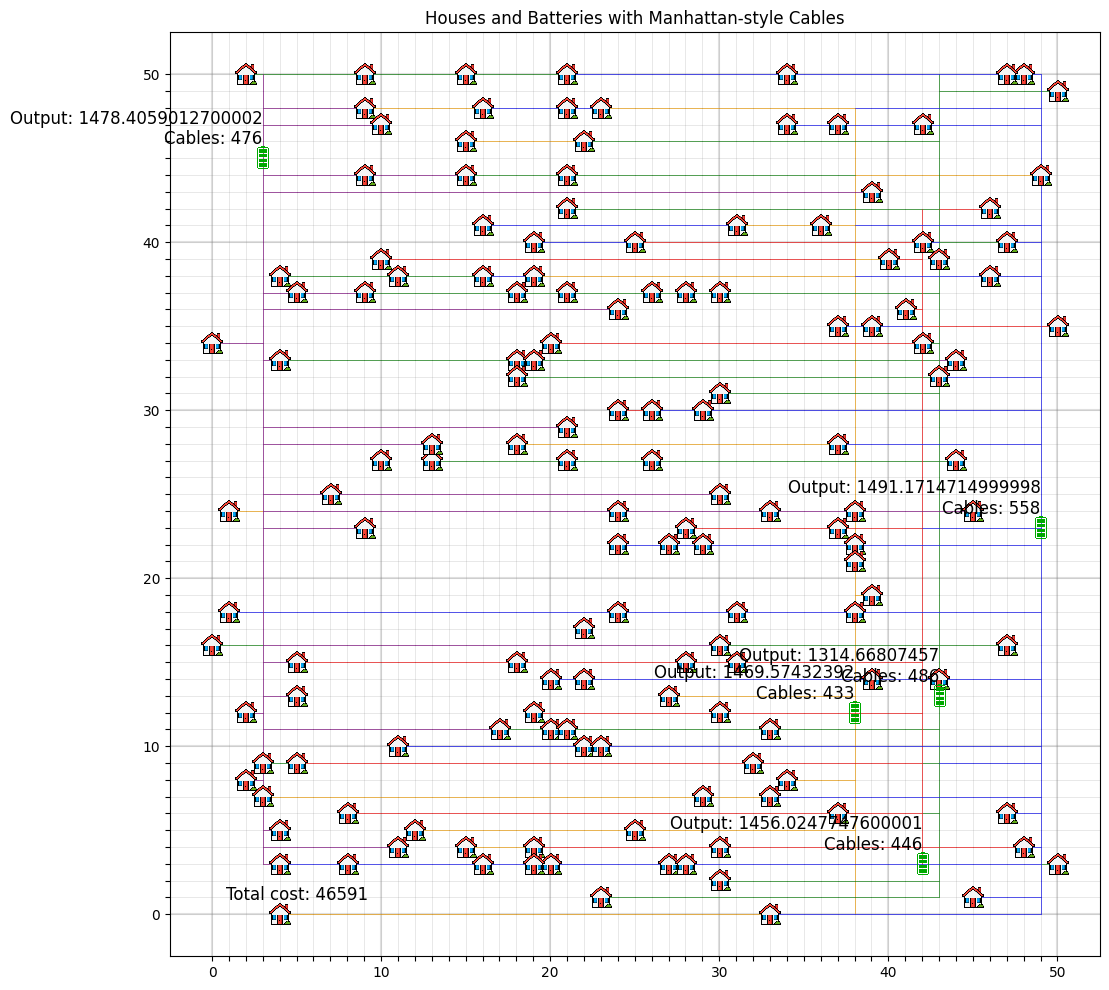

Lowest costs: 39454 for algorithm RandomAlgorithm
2/5: Running nearest_battery Simulation


Simulating nearest_battery: 100%|██████████| 1000/1000 [00:09<00:00, 101.07it/s]


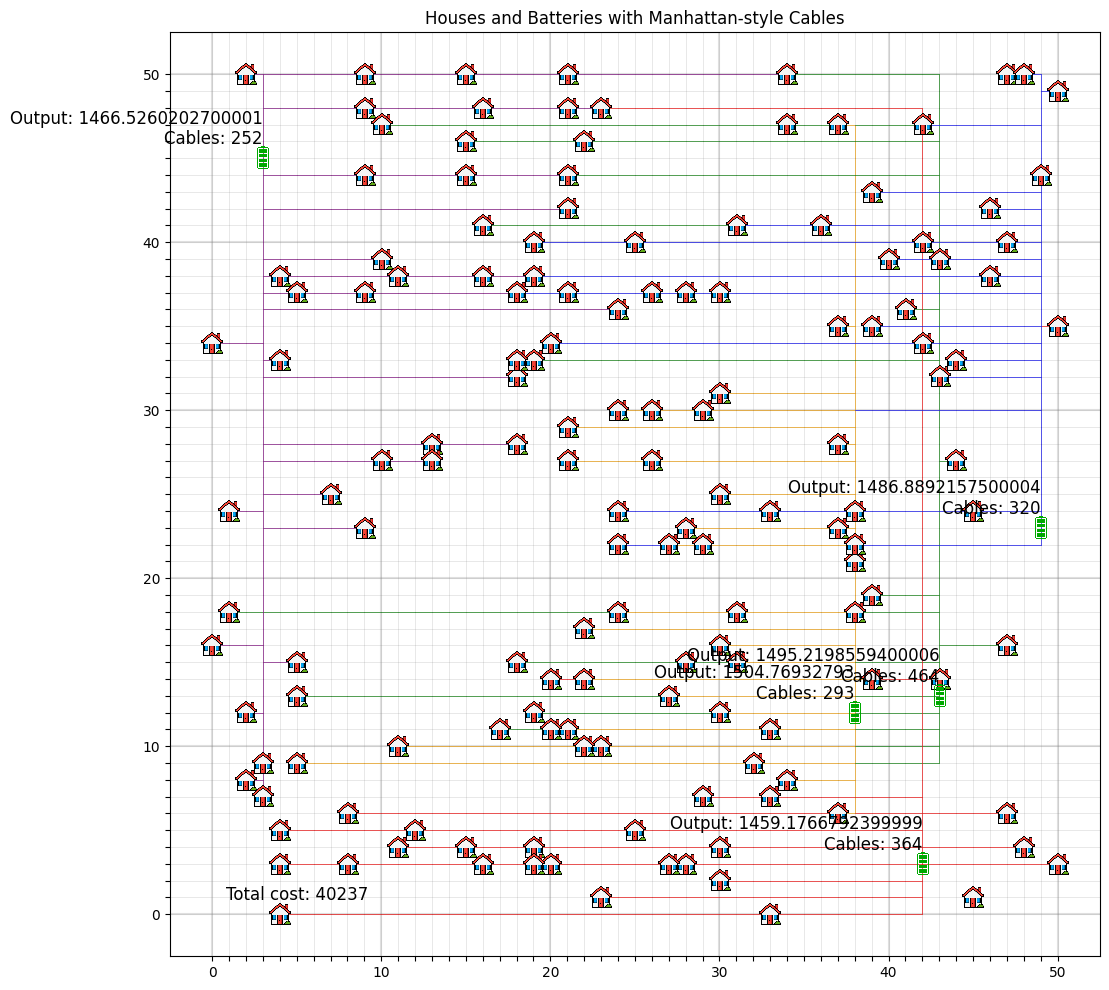

Lowest costs: 37762 for algorithm nearest_battery
3/5: Running nearest_object_x Simulation


Simulating nearest_object_x: 100%|██████████| 1000/1000 [01:56<00:00,  8.60it/s]


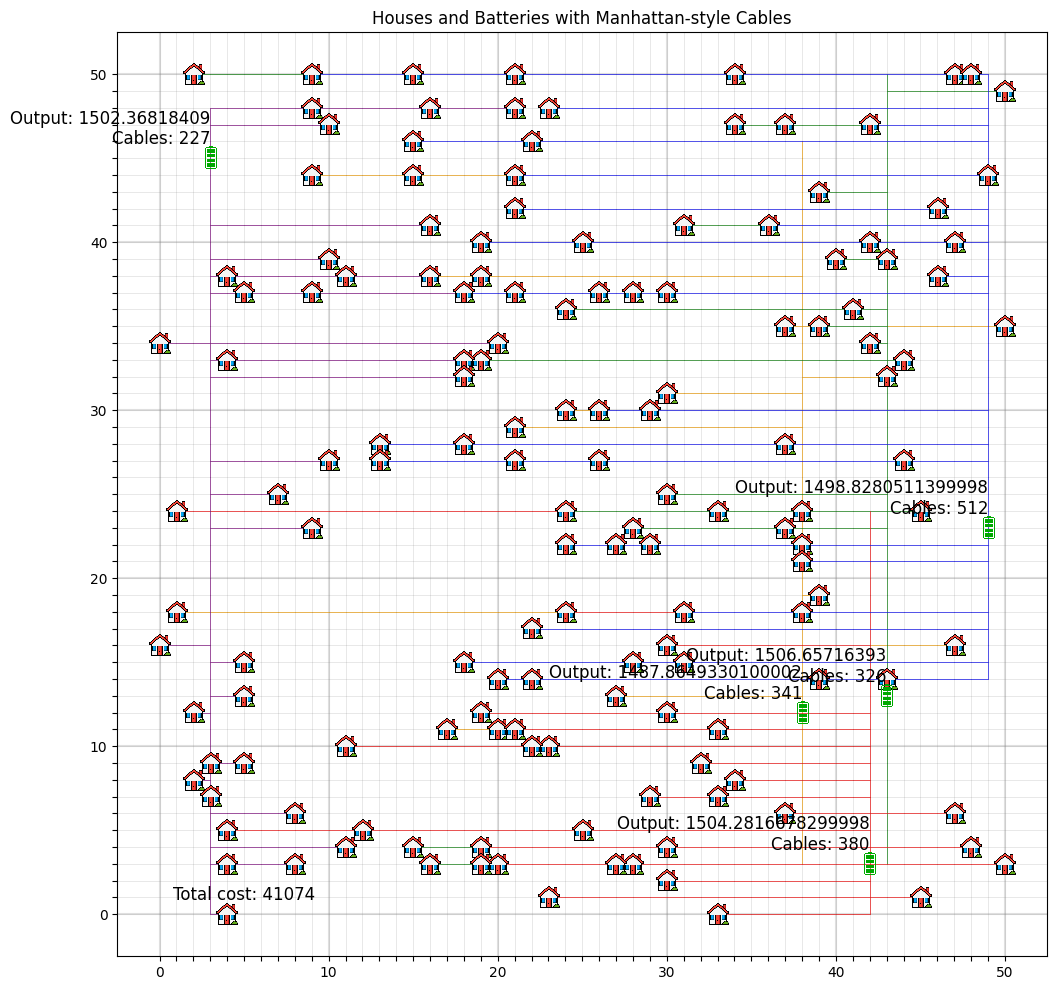

Lowest costs: 37618 for algorithm nearest_object_x
4/5: Running nearest_object_y Simulation


Simulating nearest_object_y: 100%|██████████| 1000/1000 [01:37<00:00, 10.23it/s]


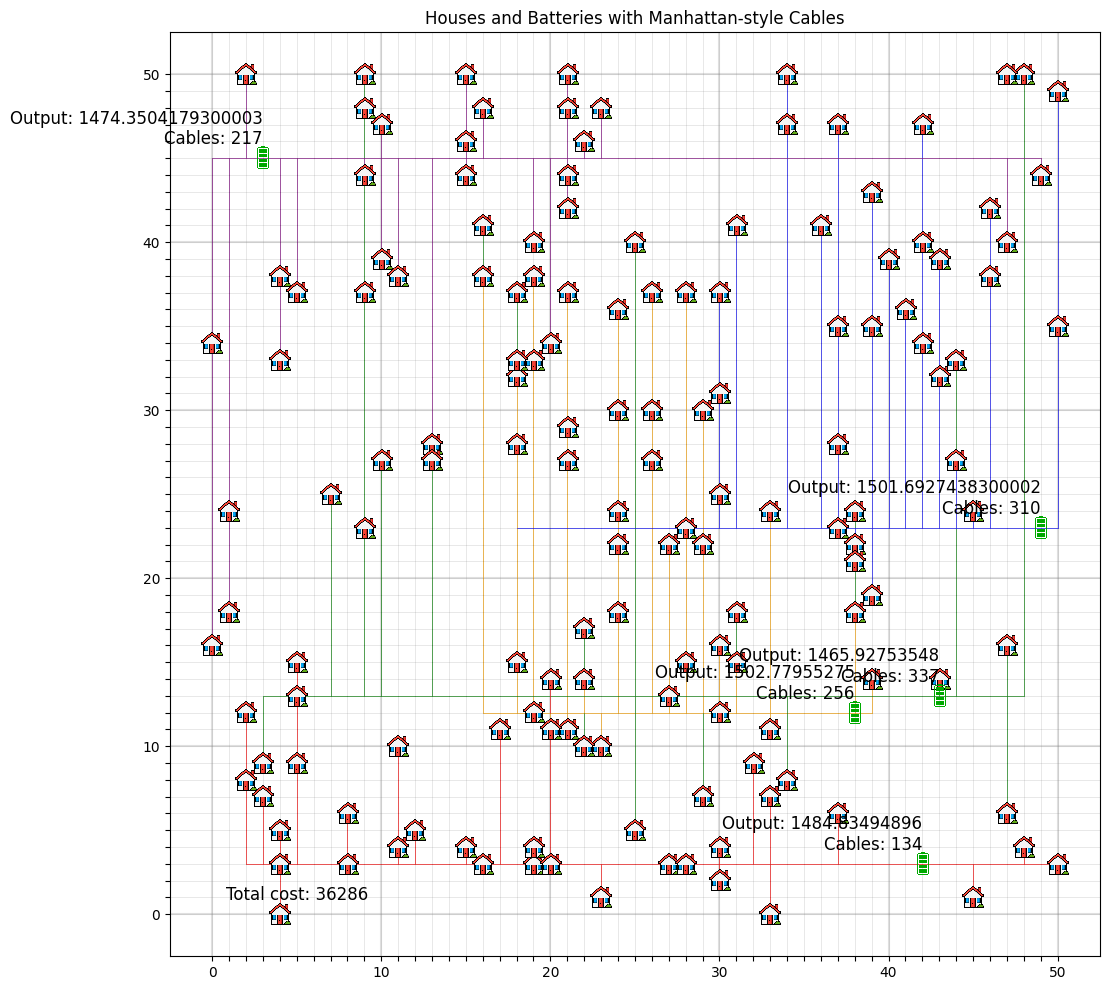

Lowest costs: 35143 for algorithm nearest_object_y
5/6: Running nearest_object_rand Simulation


Simulating nearest_object_rand: 100%|██████████| 1000/1000 [02:10<00:00,  7.68it/s]


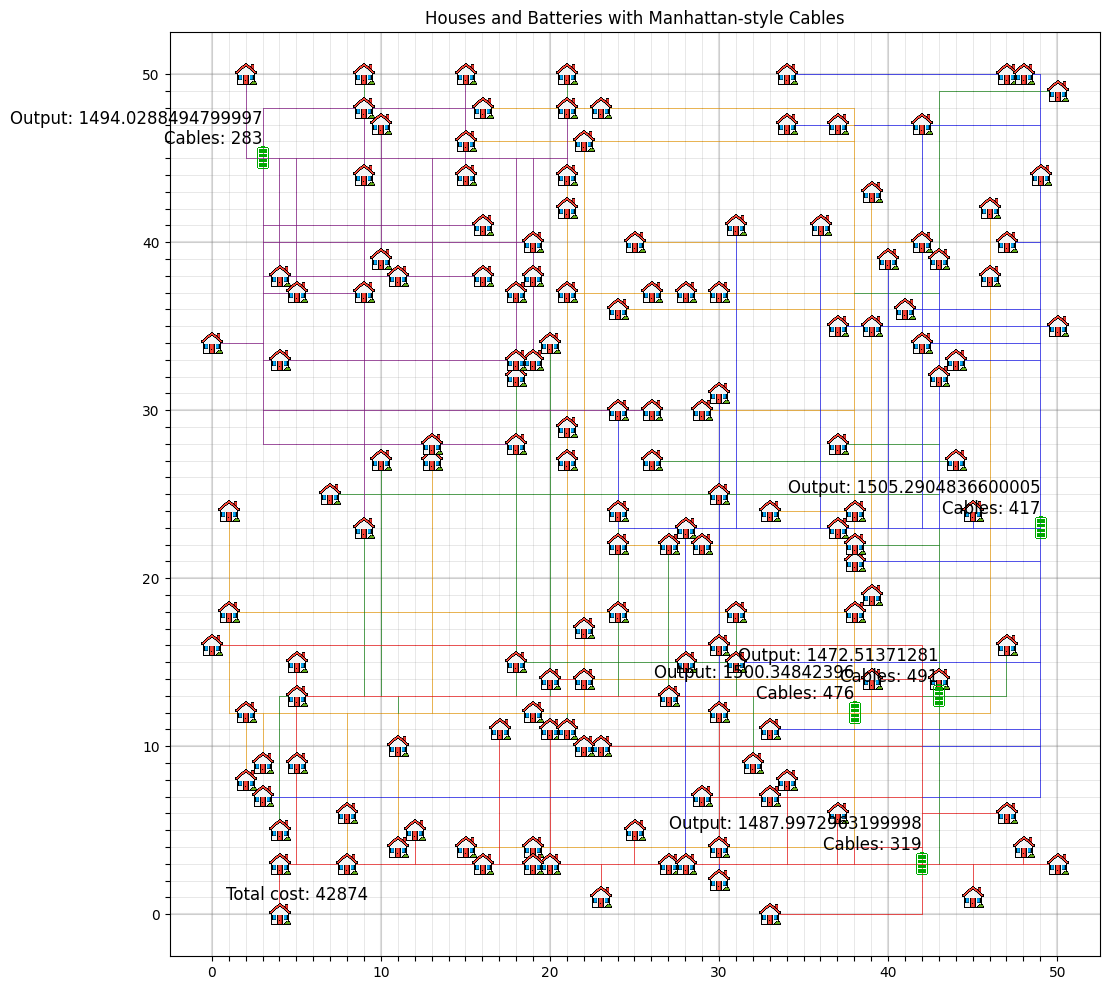

Lowest costs: 39265 for algorithm nearest_object_rand
6/6: Running dijckstra Simulation


Simulating dijckstra: 100%|██████████| 1000/1000 [01:23<00:00, 11.97it/s]


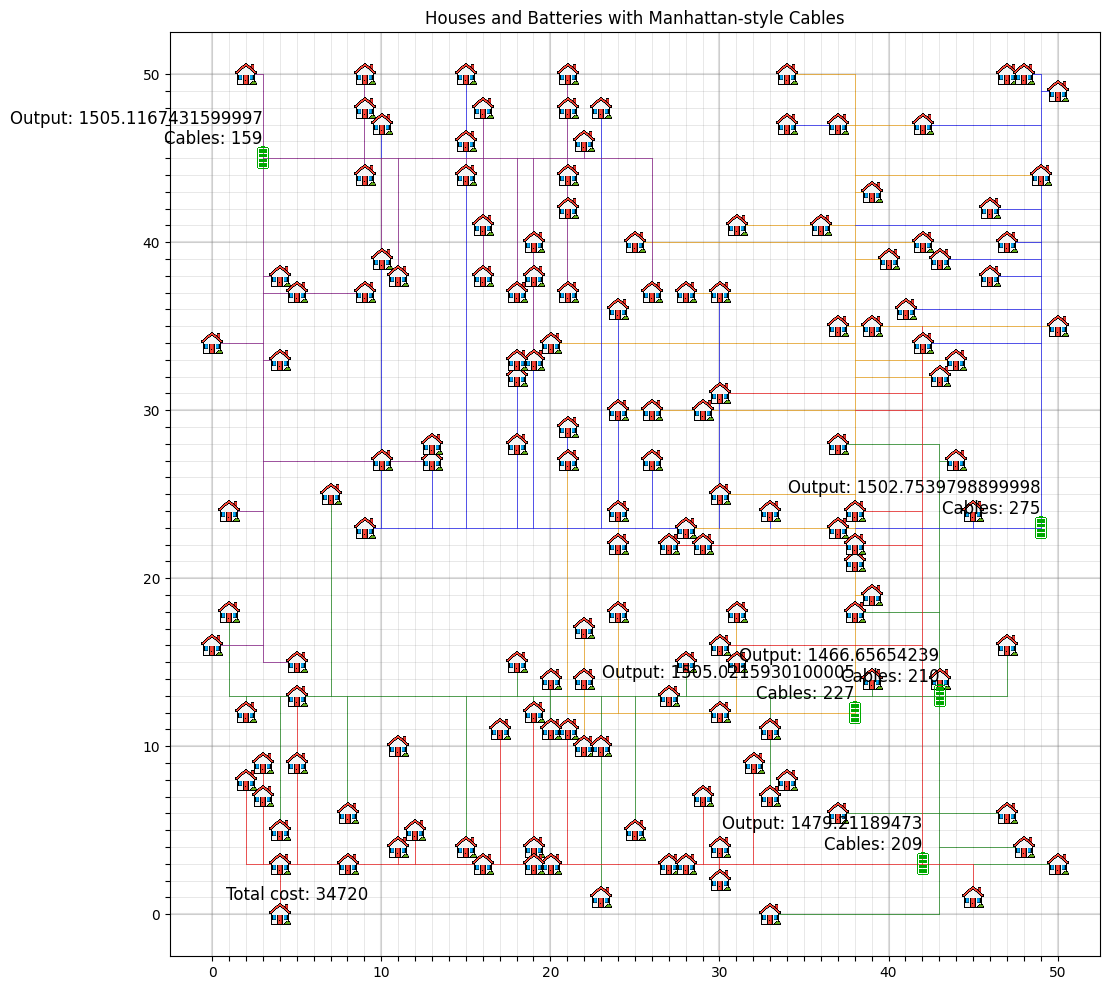

Lowest costs: 34126 for algorithm dijckstra


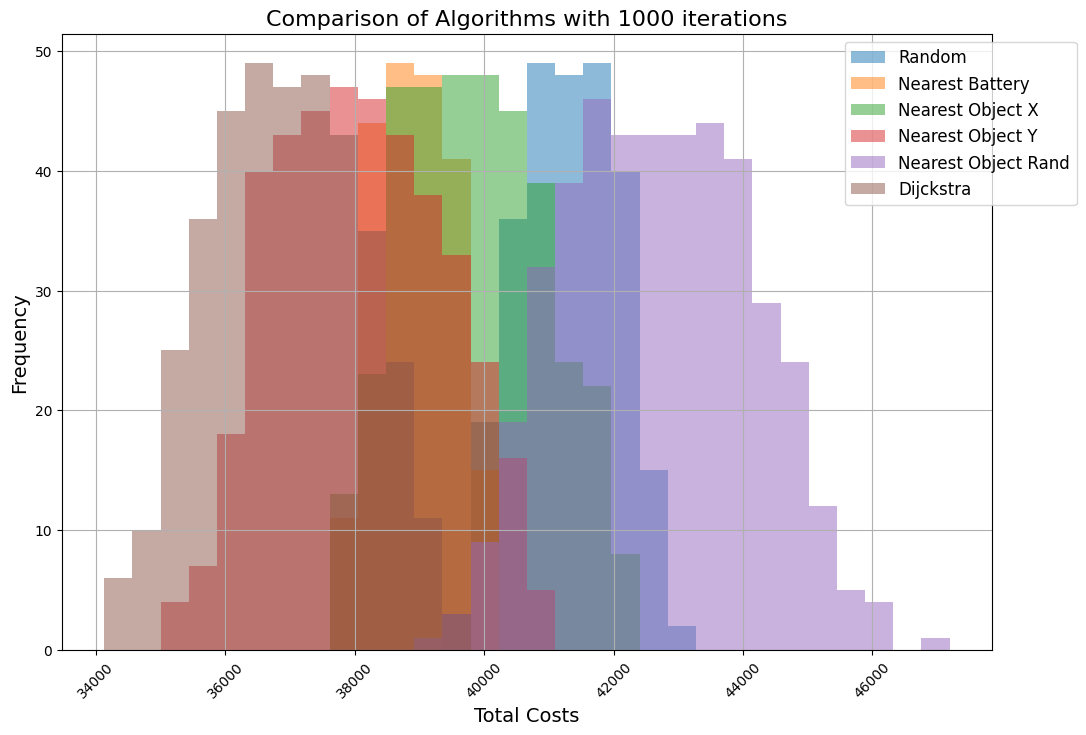

In [159]:
### Drawing cables for all districts
districts_houses = ['data/Huizen&Batterijen/district_1/district-1_houses.csv', 'data/Huizen&Batterijen/district_2/district-2_houses.csv', 'data/Huizen&Batterijen/district_3/district-3_houses.csv']
districts_batteries = ['data/Huizen&Batterijen/district_1/district-1_batteries.csv', 'data/Huizen&Batterijen/district_2/district-2_batteries.csv', 'data/Huizen&Batterijen/district_3/district-3_batteries.csv']
 
#Iterations for animation
iterations = 1000

# for each district
for i in range(0, 1):
    print(f'District {i+1}')
    # set up experiment

    experiment(districts_houses[i], districts_batteries[i], iterations)

District 1
1/2: Running RandomAlgorithm Simulation


Simulating dijckstra: 100%|██████████| 100/100 [00:09<00:00, 10.32it/s]


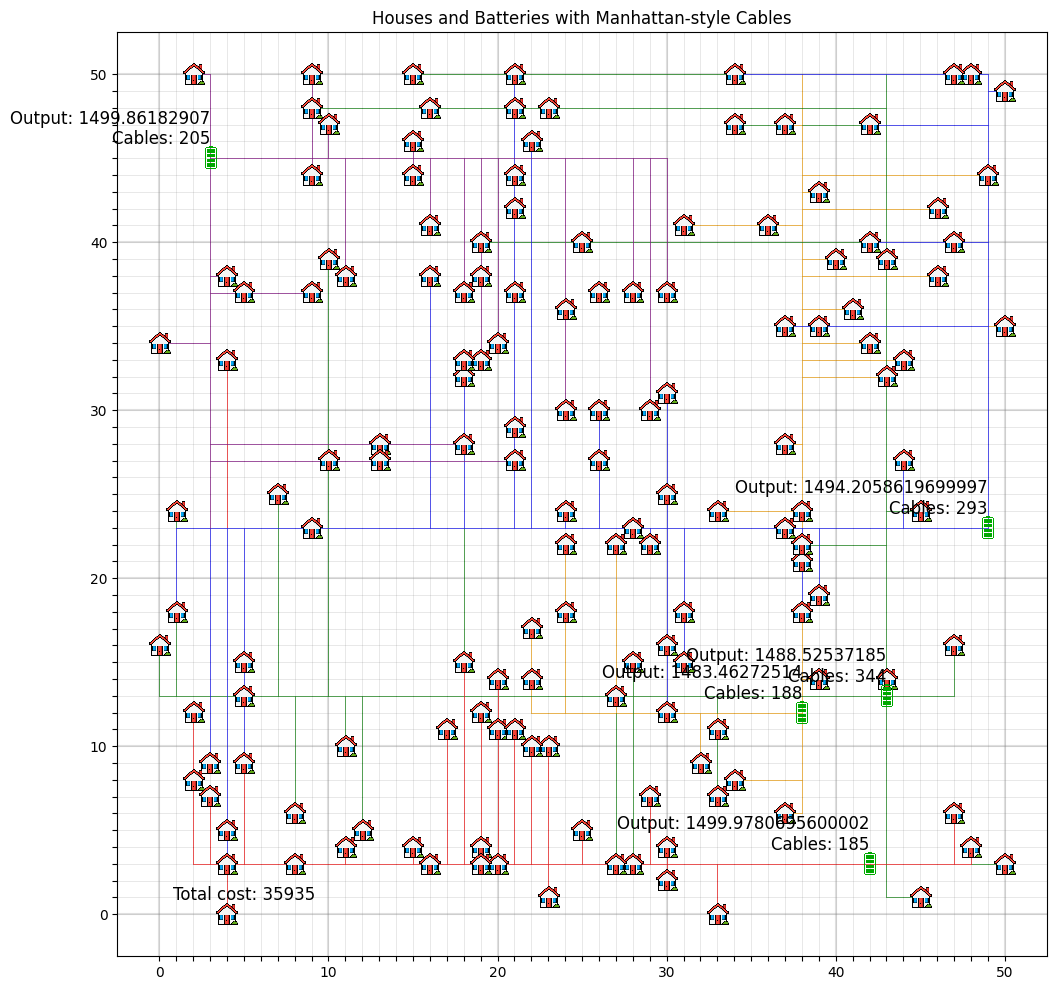

Lowest costs: 34846 for algorithm dijckstra
1/2: Running RandomAlgorithm Simulation


Simulating dijckstra_max: 100%|██████████| 100/100 [00:09<00:00, 10.63it/s]


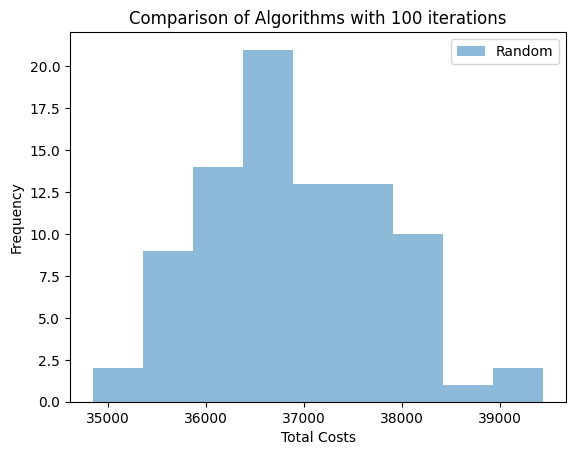

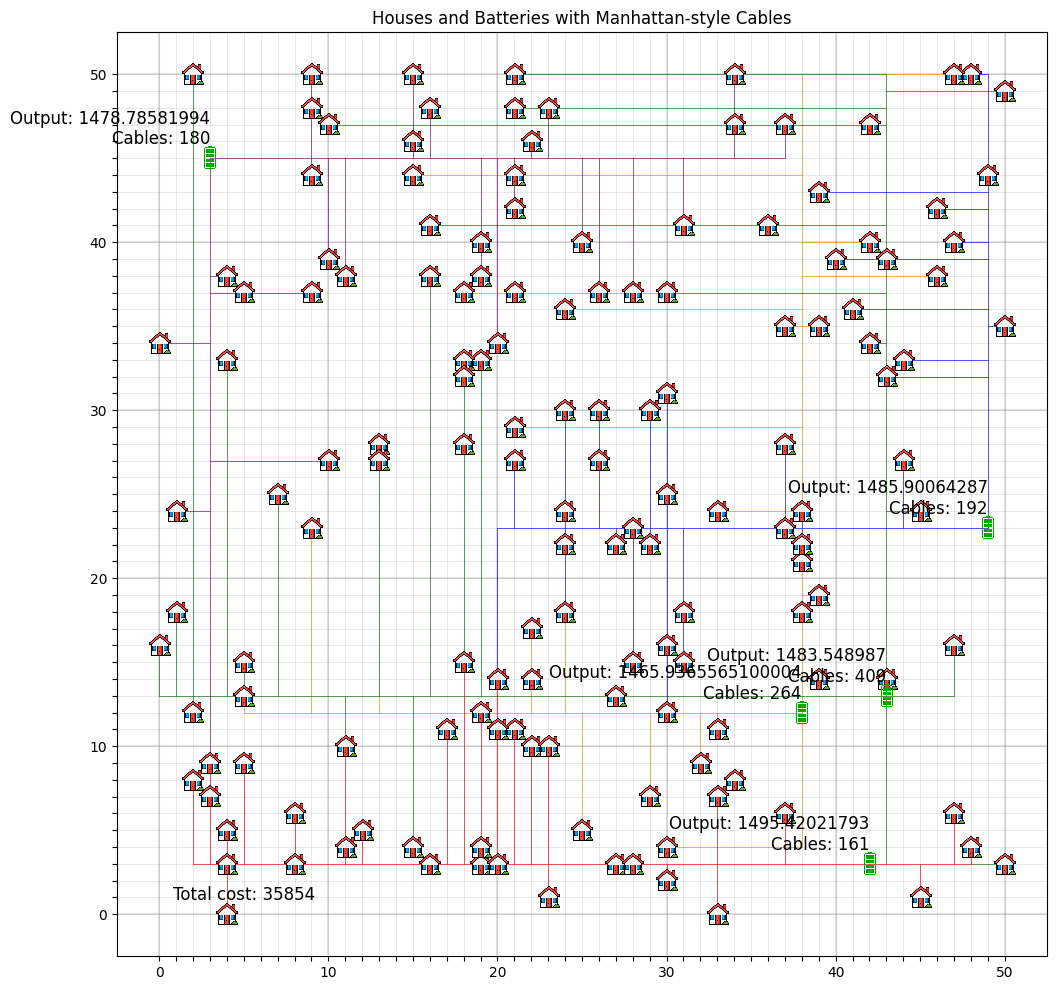

Lowest costs: 35197 for algorithm dijckstra_max
1/2: Running RandomAlgorithm Simulation


Simulating dijckstra_sum: 100%|██████████| 100/100 [00:09<00:00, 10.02it/s]


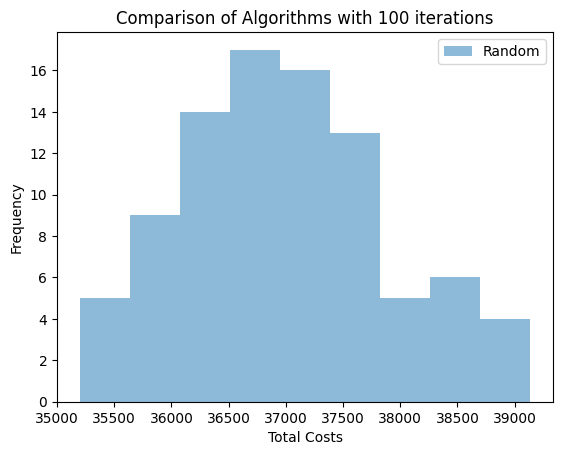

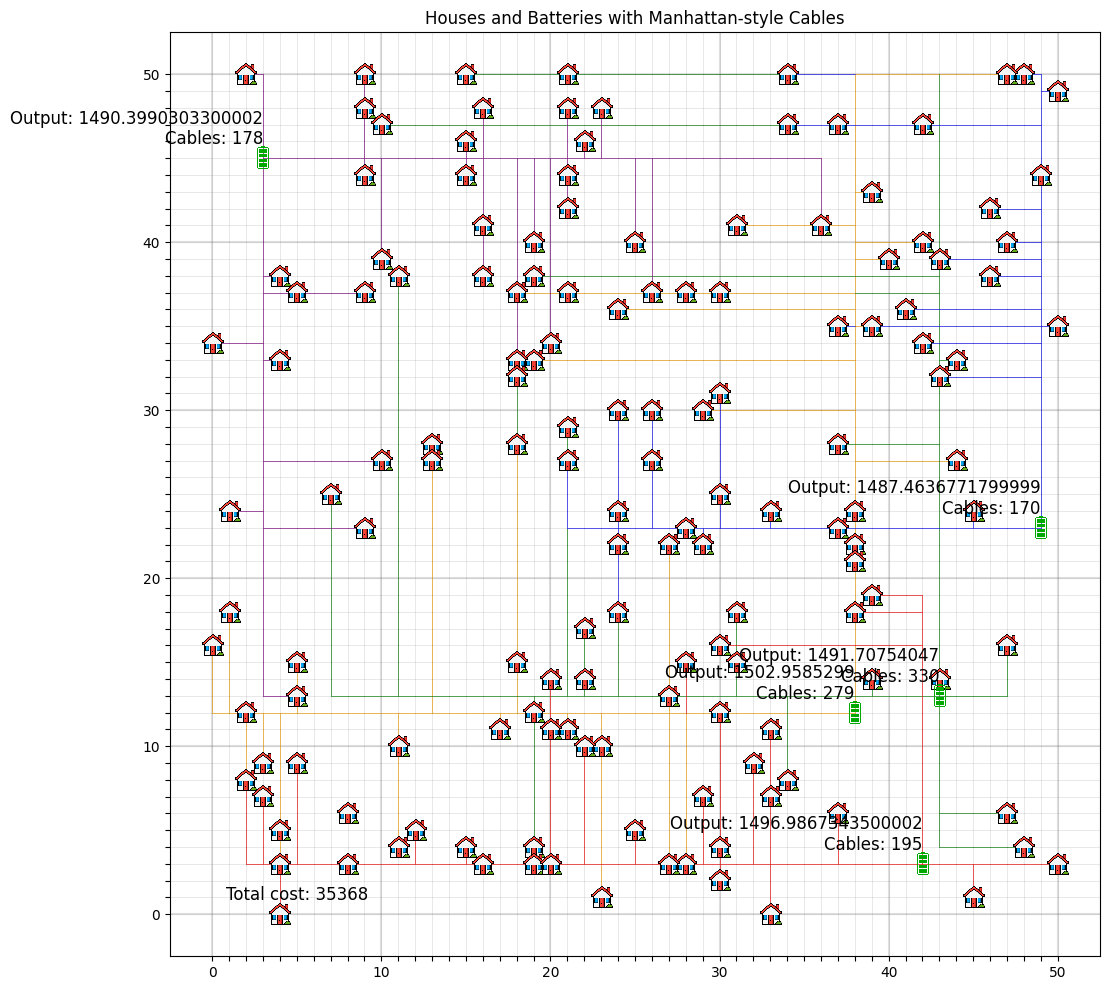

Lowest costs: 34333 for algorithm dijckstra_sum


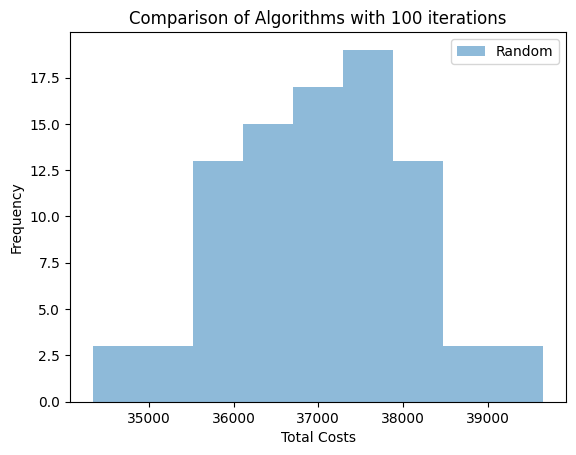

In [186]:
### Drawing cables for all districts
districts_houses = ['data/Huizen&Batterijen/district_1/district-1_houses.csv', 'data/Huizen&Batterijen/district_2/district-2_houses.csv', 'data/Huizen&Batterijen/district_3/district-3_houses.csv']
districts_batteries = ['data/Huizen&Batterijen/district_1/district-1_batteries.csv', 'data/Huizen&Batterijen/district_2/district-2_batteries.csv', 'data/Huizen&Batterijen/district_3/district-3_batteries.csv']
 
#Iterations for animation
iterations = 1000000

# for each district
for i in range(0, 1):
    print(f'District {i+1}')
    # set up experiment

    experiment2(districts_houses[i], districts_batteries[i], iterations,algorithm=dijckstra)
    #experiment2(districts_houses[i], districts_batteries[i], iterations,algorithm=dijckstra_max)
    #experiment2(districts_houses[i], districts_batteries[i], iterations,algorithm=dijckstra_sum)

District 1
1/2: Running RandomAlgorithm Simulation


Simulating dijckstra: 100%|██████████| 1000/1000 [01:30<00:00, 11.07it/s]


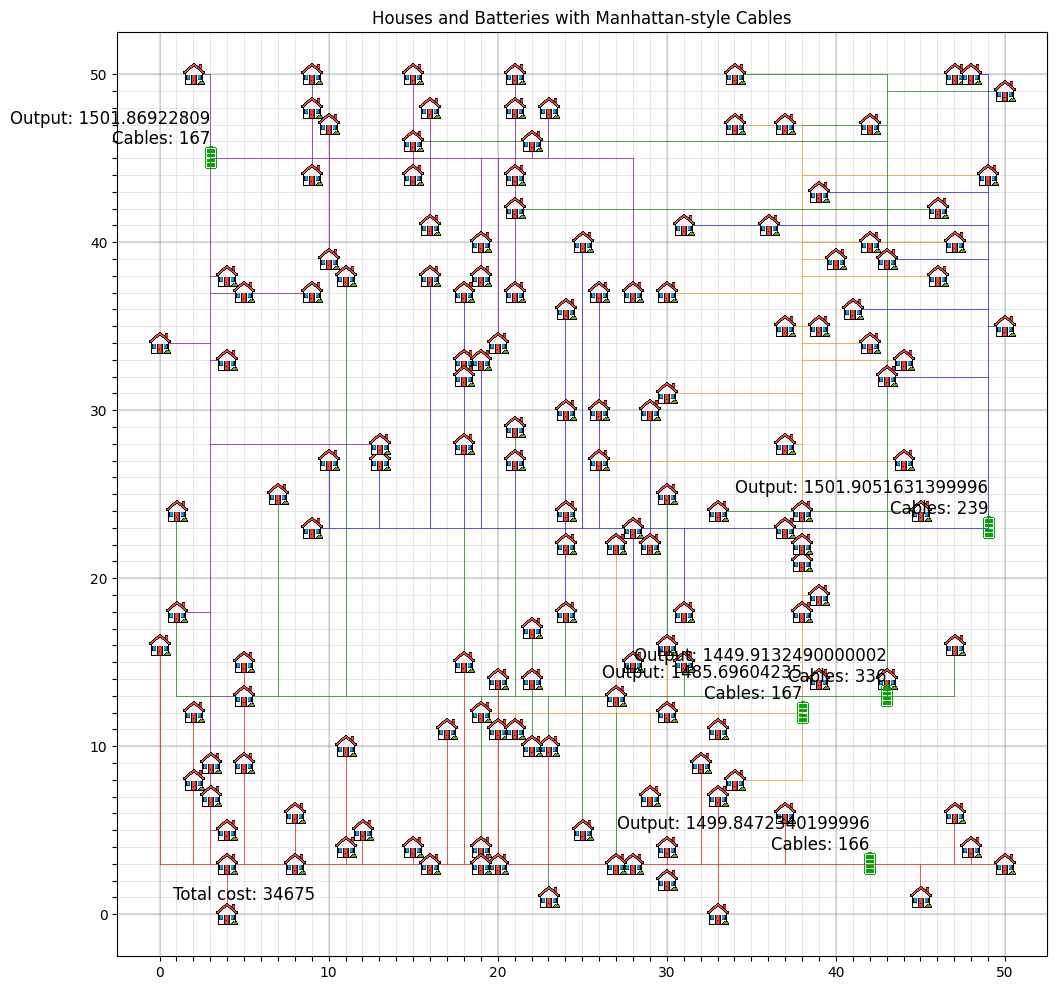

Lowest costs: 34252 for algorithm dijckstra
District 2
1/2: Running RandomAlgorithm Simulation


Simulating dijckstra: 100%|██████████| 1000/1000 [01:12<00:00, 13.86it/s]


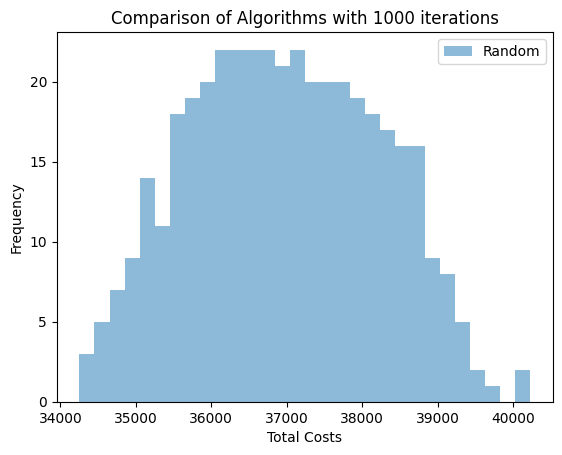

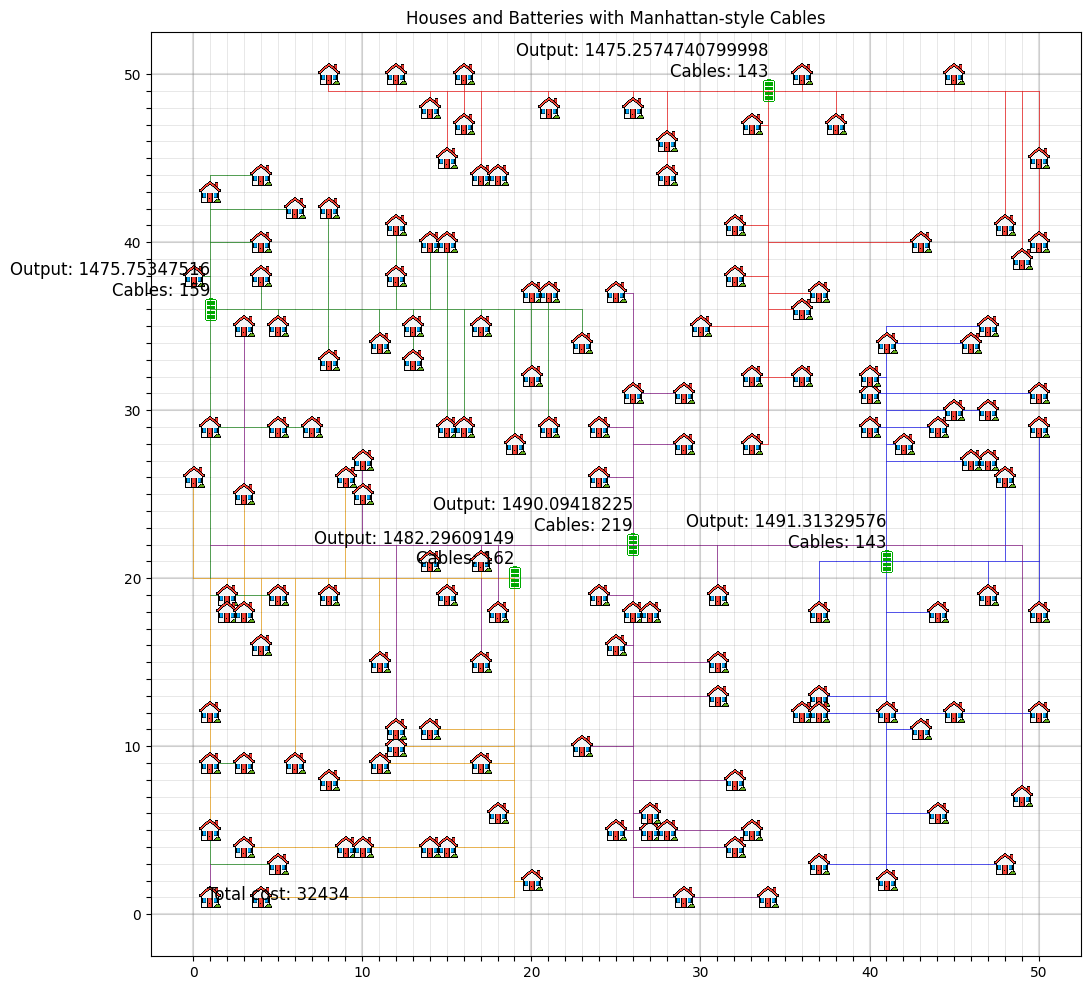

Lowest costs: 32092 for algorithm dijckstra
District 3
1/2: Running RandomAlgorithm Simulation


Simulating dijckstra: 100%|██████████| 1000/1000 [01:03<00:00, 15.76it/s]


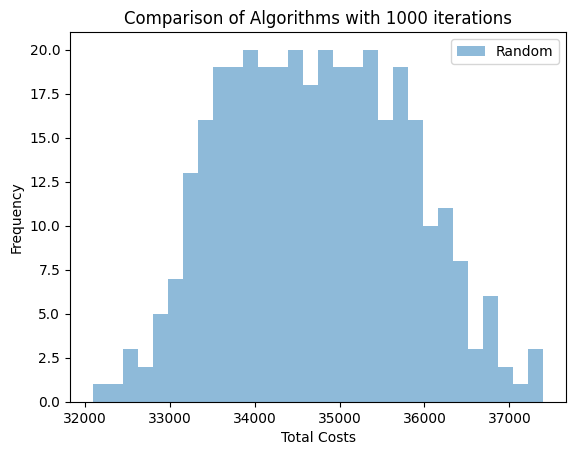

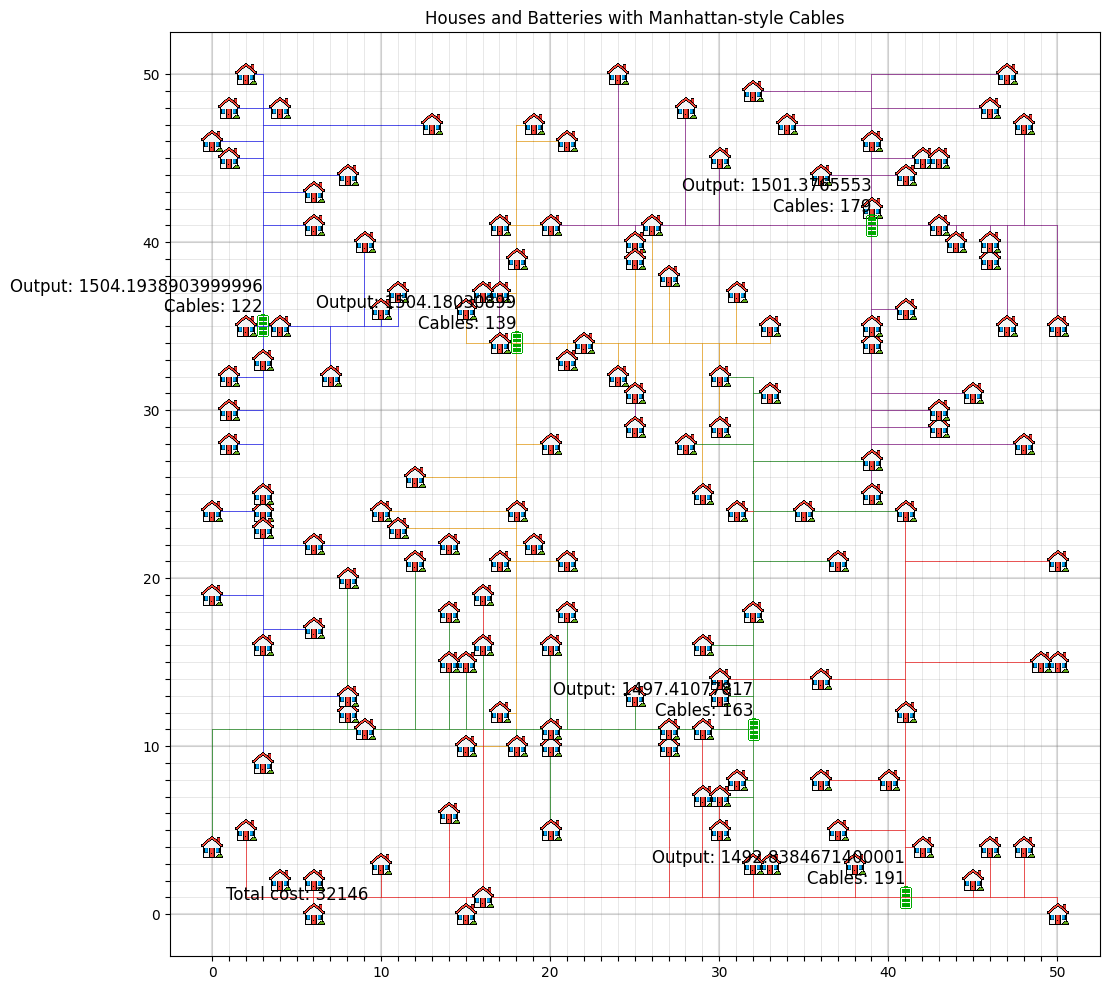

Lowest costs: 31894 for algorithm dijckstra


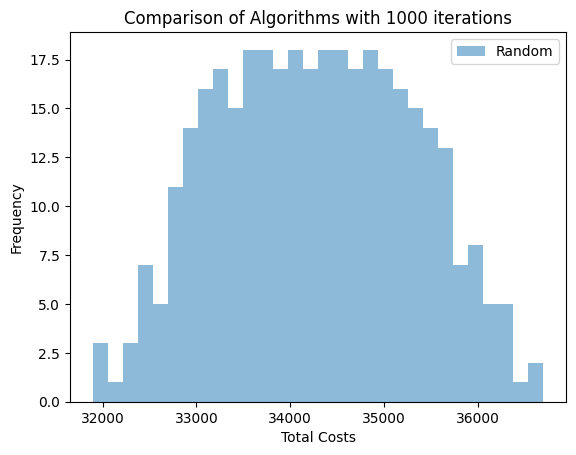

In [168]:
### Drawing cables for all districts
districts_houses = ['data/Huizen&Batterijen/district_1/district-1_houses.csv', 'data/Huizen&Batterijen/district_2/district-2_houses.csv', 'data/Huizen&Batterijen/district_3/district-3_houses.csv']
districts_batteries = ['data/Huizen&Batterijen/district_1/district-1_batteries.csv', 'data/Huizen&Batterijen/district_2/district-2_batteries.csv', 'data/Huizen&Batterijen/district_3/district-3_batteries.csv']
 
#Iterations for animation
iterations = 1000

# for each district
for i in range(0, 1):
    print(f'District {i+1}')
    # set up experiment

    experiment2(districts_houses[i], districts_batteries[i], iterations,algorithm=dijckstra)